In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. GPU/시스템 정보 확인

In [2]:
# GPU/시스템 정보 확인
%%bash
echo "========================================================================"
echo "🖥️ 시스템 정보"
echo "========================================================================"
echo ""
echo "📅 현재 시간: $(date '+%Y-%m-%d %H:%M:%S')"
echo ""
echo "🔧 GPU 정보:"
nvidia-smi --query-gpu=name,memory.total,driver_version --format=csv,noheader
echo ""
echo "🔧 CUDA 버전:"
nvcc --version 2>/dev/null | grep "release" || echo "nvcc not found"
echo ""
echo "🔧 Python 버전:"
python --version
echo ""
echo "🔧 디스크 공간:"
df -h /content | tail -1 | awk '{print "   사용: " $3 " / " $2 " (" $5 " 사용중)"}'
echo ""
echo "========================================================================"

🖥️ 시스템 정보

📅 현재 시간: 2026-01-15 03:01:33

🔧 GPU 정보:
NVIDIA A100-SXM4-80GB, 81920 MiB, 550.54.15

🔧 CUDA 버전:
Cuda compilation tools, release 12.5, V12.5.82

🔧 Python 버전:
Python 3.12.12

🔧 디스크 공간:
   사용: 39G / 236G (17% 사용중)



# 2. Miniconda + UV 설치

In [3]:
# Miniconda + UV 설치
%%bash
set -e

echo "========================================================================"
echo "📦 Miniconda + UV 설치"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

# Miniconda 설치
if [ ! -d "/content/conda" ]; then
    echo "1️⃣ Miniconda 다운로드 및 설치..."
    wget -q https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh -O /tmp/miniconda.sh
    bash /tmp/miniconda.sh -b -p /content/conda > /dev/null 2>&1
    rm /tmp/miniconda.sh
    echo "   ✅ Miniconda 설치 완료"
else
    echo "1️⃣ Miniconda 이미 설치됨"
fi

# UV 설치 (base 환경에)
if [ ! -f "/content/conda/bin/uv" ]; then
    echo "2️⃣ UV 설치..."
    /content/conda/bin/pip install uv -q
    echo "   ✅ UV 설치 완료"
else
    echo "2️⃣ UV 이미 설치됨"
fi

echo ""
echo "📋 UV 버전:"
/content/conda/bin/uv --version

echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

📦 Miniconda + UV 설치
📅 시작: 03:01:33

1️⃣ Miniconda 다운로드 및 설치...
   ✅ Miniconda 설치 완료
2️⃣ UV 설치...
   ✅ UV 설치 완료

📋 UV 버전:
uv 0.9.25

📅 완료: 03:01:49


# 3. Anaconda ToS 동의 + Python 3.10 환경 생성

In [4]:
# Anaconda ToS 동의 + Python 3.10 conda 환경 생성
%%bash
set -e

echo "========================================================================"
echo "🐍 Python 3.10 conda 환경 생성"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

source /content/conda/bin/activate

# Anaconda Terms of Service 동의
echo "1️⃣ Anaconda Terms of Service 동의..."
conda config --set solver classic 2>/dev/null || true
echo "y" | conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/main 2>/dev/null || true
echo "y" | conda tos accept --override-channels --channel https://repo.anaconda.com/pkgs/r 2>/dev/null || true
conda config --add channels conda-forge 2>/dev/null || true
conda config --set channel_priority flexible 2>/dev/null || true
echo "   ✅ 설정 완료"
echo ""

if [ ! -d "/content/conda/envs/openmmlab" ]; then
    echo "2️⃣ openmmlab 환경 생성 중..."
    conda create -n openmmlab python=3.10 -c conda-forge -y -q 2>&1 | tail -5
    echo "   ✅ 환경 생성 완료"
else
    echo "2️⃣ openmmlab 환경 이미 존재"
fi

echo ""
echo "📋 Python 버전 확인:"
/content/conda/envs/openmmlab/bin/python --version
echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

🐍 Python 3.10 conda 환경 생성
📅 시작: 03:01:49

1️⃣ Anaconda Terms of Service 동의...
accepted Terms of Service for https://repo.anaconda.com/pkgs/main
accepted Terms of Service for https://repo.anaconda.com/pkgs/r
   ✅ 설정 완료

2️⃣ openmmlab 환경 생성 중...


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
   ✅ 환경 생성 완료

📋 Python 버전 확인:
Python 3.10.19

📅 완료: 03:02:27


# 4. NumPy 1.26.4 설치

In [5]:
# NumPy 1.26.4 설치
%%bash
set -e

echo "========================================================================"
echo "📦 NumPy 1.26.4 설치"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv

echo "1️⃣ NumPy 설치 중..."
$UV pip install numpy==1.26.4 --python $PY -q

echo ""
echo "📋 NumPy 버전 확인:"
$PY -c "import numpy; print(f'   NumPy: {numpy.__version__}')"
echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

📦 NumPy 1.26.4 설치
📅 시작: 03:02:27

1️⃣ NumPy 설치 중...

📋 NumPy 버전 확인:
   NumPy: 1.26.4

📅 완료: 03:02:28


# 5. PyTorch 2.1.2 + CUDA 11.8 설치

In [6]:
# PyTorch 2.1.2 + CUDA 11.8 설치
%%bash
set -e

echo "========================================================================"
echo "🔥 PyTorch 2.1.2 + CUDA 11.8 설치"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv

echo "1️⃣ PyTorch 설치 중 (약 1분 소요)..."
$UV pip install torch==2.1.2 torchvision==0.16.2 \
    --index-url https://download.pytorch.org/whl/cu118 \
    --python $PY -q

echo ""
echo "📋 설치 확인:"
$PY -c "
import torch
print(f'   PyTorch: {torch.__version__}')
print(f'   CUDA 사용 가능: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'   GPU: {torch.cuda.get_device_name(0)}')
    print(f'   CUDA 버전: {torch.version.cuda}')
"

echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

🔥 PyTorch 2.1.2 + CUDA 11.8 설치
📅 시작: 03:02:28

1️⃣ PyTorch 설치 중 (약 1분 소요)...

📋 설치 확인:
   PyTorch: 2.1.2+cu118
   CUDA 사용 가능: True
   GPU: NVIDIA A100-SXM4-80GB
   CUDA 버전: 11.8

📅 완료: 03:02:57


# 6. OpenMMLab 스택 설치

In [7]:
# OpenMMLab 스택 설치 (mmcv, mmengine, mmdet)
%%bash
set -e

echo "========================================================================"
echo "📦 OpenMMLab 스택 설치"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv

echo "1️⃣ mmcv 2.1.0 설치 중..."
$UV pip install mmcv==2.1.0 \
    -f https://download.openmmlab.com/mmcv/dist/cu118/torch2.1/index.html \
    --python $PY -q
echo "   ✅ mmcv 설치 완료"

echo "2️⃣ mmengine 설치 중..."
$UV pip install mmengine==0.10.7 --python $PY -q
echo "   ✅ mmengine 설치 완료"

echo "3️⃣ mmdet 설치 중..."
$UV pip install mmdet==3.3.0 --python $PY -q
echo "   ✅ mmdet 설치 완료"

echo ""
echo "📋 설치 확인:"
$PY -c "
import mmcv
import mmengine
import mmdet
print(f'   mmcv: {mmcv.__version__}')
print(f'   mmengine: {mmengine.__version__}')
print(f'   mmdet: {mmdet.__version__}')
"

echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

📦 OpenMMLab 스택 설치
📅 시작: 03:02:57

1️⃣ mmcv 2.1.0 설치 중...
   ✅ mmcv 설치 완료
2️⃣ mmengine 설치 중...
   ✅ mmengine 설치 완료
3️⃣ mmdet 설치 중...
   ✅ mmdet 설치 완료

📋 설치 확인:
   mmcv: 2.1.0
   mmengine: 0.10.7
   mmdet: 3.3.0

📅 완료: 03:03:03


# 7. MMDetection3D v1.4.0 설치 + 패치

In [8]:
# MMDetection3D v1.4.0 설치 + np.long 패치
%%bash
set -e

echo "========================================================================"
echo "📦 MMDetection3D v1.4.0 설치"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv

cd /content

# 클론
if [ ! -d "mmdetection3d" ]; then
    echo "1️⃣ MMDetection3D 클론 중..."
    git clone -b v1.4.0 --depth 1 https://github.com/open-mmlab/mmdetection3d.git 2>/dev/null
    echo "   ✅ 클론 완료"
else
    echo "1️⃣ MMDetection3D 이미 존재"
fi

# 런타임 의존성 설치
echo "2️⃣ 런타임 의존성 설치 중..."
cd mmdetection3d
$UV pip install -r requirements/runtime.txt --python $PY -q 2>/dev/null || true
$UV pip install "nuscenes-devkit==1.1.11" --python $PY -q 2>/dev/null || true
echo "   ✅ 의존성 설치 완료"

# np.long → np.int64 패치
echo "3️⃣ NumPy 호환성 패치 적용 중..."
find /content/mmdetection3d -name "*.py" -exec grep -l "np\.long[^a-z]" {} \; 2>/dev/null | while read f; do
    sed -i 's/np\.long\([^a-z]\)/np.int64\1/g' "$f"
done
echo "   ✅ np.long → np.int64 패치 완료"

echo ""
echo "📋 설치 확인:"
export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH
$PY -c "import mmdet3d; print(f'   mmdet3d: {mmdet3d.__version__}')"

echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

📦 MMDetection3D v1.4.0 설치
📅 시작: 03:03:03

1️⃣ MMDetection3D 클론 중...
   ✅ 클론 완료
2️⃣ 런타임 의존성 설치 중...
   ✅ 의존성 설치 완료
3️⃣ NumPy 호환성 패치 적용 중...
   ✅ np.long → np.int64 패치 완료

📋 설치 확인:
   mmdet3d: 1.4.0

📅 완료: 03:03:23


# 8. numba 0.56.4 설치 (PTX 호환성) + 의존성 검증

In [9]:
# numba 설정 (CUDA 비활성화 + CPU fallback)
%%bash
set -e

echo "========================================================================"
echo "🔧 numba 설정 (CUDA 호환성 문제 해결)"
echo "========================================================================"
echo "📅 시작: $(date '+%H:%M:%S')"
echo ""

PY=/content/conda/envs/openmmlab/bin/python
UV=/content/conda/bin/uv
export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH

# numba 0.57.1 설치 (중간 버전)
echo "1️⃣ numba 0.57.1 + llvmlite 0.40.1 설치..."
$UV pip uninstall numba llvmlite -y --python $PY -q 2>/dev/null || true
$UV pip install numba==0.57.1 llvmlite==0.40.1 --python $PY -q
echo "   ✅ numba 0.57.1 설치 완료"

# numba 캐시 삭제
echo ""
echo "2️⃣ numba 캐시 삭제..."
rm -rf ~/.cache/numba
rm -rf /root/.cache/numba
rm -rf /content/mmdetection3d/mmdet3d/evaluation/functional/kitti_utils/__pycache__
find /content/mmdetection3d -name "*.nbc" -delete 2>/dev/null || true
find /content/mmdetection3d -name "*.nbi" -delete 2>/dev/null || true
echo "   ✅ 캐시 삭제 완료"

# ⚠️ 핵심: numba CUDA 비활성화 설정 파일 생성
echo ""
echo "3️⃣ numba CUDA 비활성화 설정..."
mkdir -p /content/conda/envs/openmmlab/etc/conda/activate.d
cat > /content/conda/envs/openmmlab/etc/conda/activate.d/env_vars.sh << 'ENVEOF'
#!/bin/bash
export NUMBA_DISABLE_CUDA=1
ENVEOF
chmod +x /content/conda/envs/openmmlab/etc/conda/activate.d/env_vars.sh
echo "   ✅ NUMBA_DISABLE_CUDA=1 설정 완료"

echo ""
echo "4️⃣ 의존성 확인:"
$PY << 'EOF'
import os
os.environ['NUMBA_DISABLE_CUDA'] = '1'  # Python 내에서도 설정

import sys
print(f"   Python: {sys.version.split()[0]}")

import numpy as np
print(f"   NumPy: {np.__version__}")

import torch
print(f"   PyTorch: {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")

import mmcv
print(f"   mmcv: {mmcv.__version__}")

import mmengine
print(f"   mmengine: {mmengine.__version__}")

import mmdet
print(f"   mmdet: {mmdet.__version__}")

import mmdet3d
print(f"   mmdet3d: {mmdet3d.__version__}")

import numba
print(f"   numba: {numba.__version__}")
print(f"   NUMBA_DISABLE_CUDA: {os.environ.get('NUMBA_DISABLE_CUDA', 'not set')}")

import llvmlite
print(f"   llvmlite: {llvmlite.__version__}")

if torch.cuda.is_available():
    print(f"\n   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
EOF

echo ""
echo "📅 완료: $(date '+%H:%M:%S')"
echo "========================================================================"

🔧 numba 설정 (CUDA 호환성 문제 해결)
📅 시작: 03:03:23

1️⃣ numba 0.57.1 + llvmlite 0.40.1 설치...
   ✅ numba 0.57.1 설치 완료

2️⃣ numba 캐시 삭제...
   ✅ 캐시 삭제 완료

3️⃣ numba CUDA 비활성화 설정...
   ✅ NUMBA_DISABLE_CUDA=1 설정 완료

4️⃣ 의존성 확인:
   Python: 3.10.19
   NumPy: 1.24.4
   PyTorch: 2.1.2+cu118
   CUDA available: True
   mmcv: 2.1.0
   mmengine: 0.10.7
   mmdet: 3.3.0
   mmdet3d: 1.4.0
   numba: 0.57.1
   NUMBA_DISABLE_CUDA: 1
   llvmlite: 0.40.1

   GPU: NVIDIA A100-SXM4-80GB
   GPU Memory: 79.3 GB

📅 완료: 03:03:27


# 9. KITTI 데이터셋 다운로드

In [10]:
# KITTI 데이터셋 다운로드
%%bash
set -e

echo "========================================================================"
echo "📥 KITTI 3D 데이터셋 다운로드"
echo "========================================================================"
echo "📅 시작 시간: $(date '+%H:%M:%S')"
echo ""

# aria2 설치
echo "1️⃣ aria2 설치 중..."
apt-get update -qq && apt-get install -y aria2 -qq 2>/dev/null
echo "   ✅ aria2 설치 완료"
echo ""

DATA_ROOT=/content/data/kitti
mkdir -p ${DATA_ROOT}
cd ${DATA_ROOT}

# 이미 완료 확인
if [ -d "training/velodyne" ] && [ $(ls training/velodyne/*.bin 2>/dev/null | wc -l) -gt 7000 ]; then
    echo "✅ KITTI 데이터가 이미 존재합니다!"
    echo "   Training: $(ls training/velodyne/*.bin | wc -l) samples"
    echo "   Testing: $(ls testing/velodyne/*.bin 2>/dev/null | wc -l) samples"
    exit 0
fi

echo "📋 다운로드할 파일:"
echo "   1. data_object_calib.zip (~16MB)"
echo "   2. data_object_label_2.zip (~5MB)"
echo "   3. data_object_image_2.zip (~12GB)"
echo "   4. data_object_velodyne.zip (~29GB)"
echo ""
echo "⏱️ 예상 소요 시간: 20-40분"
echo ""
echo "========================================================================"

download_and_extract() {
    local filename=$1
    local desc=$2
    local url="https://s3.eu-central-1.amazonaws.com/avg-kitti/${filename}"

    echo ""
    echo "━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━"
    echo "🔽 ${filename} - ${desc}"
    echo "   시작: $(date '+%H:%M:%S')"

    aria2c -x 16 -s 16 -k 1M \
        --summary-interval=60 \
        --console-log-level=notice \
        --download-result=hide \
        "${url}" -o "${filename}" 2>&1 | grep -E "(\[#|Download)" || true

    if [ -f "${filename}" ]; then
        echo "   📦 압축 해제 중..."
        unzip -q -o "${filename}"
        rm -f "${filename}"
        echo "   ✅ 완료: $(date '+%H:%M:%S')"
    fi
}

echo ""
echo "2️⃣ 파일 다운로드 시작"

download_and_extract "data_object_calib.zip" "Calibration"
download_and_extract "data_object_label_2.zip" "Labels"
download_and_extract "data_object_image_2.zip" "RGB Images"
download_and_extract "data_object_velodyne.zip" "LiDAR Point Cloud"

echo ""
echo "3️⃣ ImageSets 다운로드"
mkdir -p ImageSets
for split in train val test; do
    if [ ! -f "ImageSets/${split}.txt" ]; then
        wget -q https://raw.githubusercontent.com/traveller59/second.pytorch/master/second/data/ImageSets/${split}.txt -O ImageSets/${split}.txt
    fi
    echo "   ✅ ${split}.txt: $(wc -l < ImageSets/${split}.txt) samples"
done

echo ""
echo "========================================================================"
echo "✅ KITTI 다운로드 완료!"
echo "========================================================================"
echo "📊 데이터 통계:"
echo "   Training: $(ls training/velodyne/*.bin 2>/dev/null | wc -l) samples"
echo "   Testing: $(ls testing/velodyne/*.bin 2>/dev/null | wc -l) samples"
echo "   디스크 사용량: $(du -sh ${DATA_ROOT} | cut -f1)"
echo "📅 완료 시간: $(date '+%H:%M:%S')"
echo "========================================================================"

📥 KITTI 3D 데이터셋 다운로드
📅 시작 시간: 03:03:27

1️⃣ aria2 설치 중...
Selecting previously unselected package libc-ares2:amd64.
(Reading database ... 121689 files and directories currently installed.)
Preparing to unpack .../libc-ares2_1.18.1-1ubuntu0.22.04.3_amd64.deb ...
Unpacking libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Selecting previously unselected package libaria2-0:amd64.
Preparing to unpack .../libaria2-0_1.36.0-1_amd64.deb ...
Unpacking libaria2-0:amd64 (1.36.0-1) ...
Selecting previously unselected package aria2.
Preparing to unpack .../aria2_1.36.0-1_amd64.deb ...
Unpacking aria2 (1.36.0-1) ...
Setting up libc-ares2:amd64 (1.18.1-1ubuntu0.22.04.3) ...
Setting up libaria2-0:amd64 (1.36.0-1) ...
Setting up aria2 (1.36.0-1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.8) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero_v2.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is no

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


# 11. 데이터 전처리

In [11]:
# KITTI 데이터 전처리 (무소음/렉 방지 버전)
import subprocess
import os
from datetime import datetime
import time

print("=" * 70)
print("🔄 KITTI 데이터 전처리")
print("=" * 70)
print(f"📅 시작 시간: {datetime.now().strftime('%H:%M:%S')}")
print()

# 1. 심볼릭 링크 생성
os.makedirs('/content/mmdetection3d/data', exist_ok=True)
link_path = '/content/mmdetection3d/data/kitti'
if os.path.islink(link_path):
    os.remove(link_path)
elif os.path.exists(link_path):
    import shutil
    shutil.rmtree(link_path)
os.symlink('/content/data/kitti', link_path)
print("🔗 심볼릭 링크 생성 완료")

print("⏳ 전처리 시작 (로그 출력을 껐습니다. 약 10-15분 대기해주세요...)")
print("-" * 70)

# 2. 환경 변수 설정
env = os.environ.copy()
env['PYTHONPATH'] = '/content/mmdetection3d:' + env.get('PYTHONPATH', '')
env['PYTHONUNBUFFERED'] = '1'

cmd = [
    '/content/conda/envs/openmmlab/bin/python', '-u',
    '/content/mmdetection3d/tools/create_data.py', 'kitti',
    '--root-path', '/content/data/kitti',
    '--out-dir', '/content/data/kitti',
    '--extra-tag', 'kitti',
    '--workers', '2'
]

# 3. 프로세스 실행 (출력 차단)
start_time = time.time()

# stdout=subprocess.DEVNULL -> 출력을 화면에 뿌리지 않고 버림 (렉 해결)
process = subprocess.Popen(
    cmd,
    stdout=subprocess.DEVNULL,
    stderr=subprocess.STDOUT,
    env=env,
    cwd='/content/mmdetection3d'
)

process.wait() # 작업이 끝날 때까지 대기

end_time = time.time()
print(f"✅ 전처리 프로세스 종료 (소요 시간: {(end_time - start_time)/60:.1f}분)")
print("-" * 70)
print()
print("=" * 70)
print("✅ 전처리 결과 확인")
print("=" * 70)

# 4. 결과 파일 확인
import glob
print("\n📁 생성된 파일:")
found_files = False
for pkl in sorted(glob.glob('/content/data/kitti/*.pkl')):
    size = os.path.getsize(pkl) / 1024 / 1024
    print(f"   • {os.path.basename(pkl)}: {size:.1f} MB")
    found_files = True

reduced_dir = '/content/data/kitti/training/velodyne_reduced'
if os.path.exists(reduced_dir):
    count = len([f for f in os.listdir(reduced_dir) if f.endswith('.bin')])
    print(f"   • velodyne_reduced/: {count} files")
    found_files = True

if not found_files:
    print("⚠️ 경고: 생성된 파일이 없습니다. 경로를 확인해주세요.")

print(f"\n📅 완료 시간: {datetime.now().strftime('%H:%M:%S')}")
print("=" * 70)

🔄 KITTI 데이터 전처리
📅 시작 시간: 03:10:59

🔗 심볼릭 링크 생성 완료
⏳ 전처리 시작 (로그 출력을 껐습니다. 약 10-15분 대기해주세요...)
----------------------------------------------------------------------
✅ 전처리 프로세스 종료 (소요 시간: 5.8분)
----------------------------------------------------------------------

✅ 전처리 결과 확인

📁 생성된 파일:
   • kitti_dbinfos_train.pkl: 3.2 MB
   • kitti_infos_test.pkl: 17.6 MB
   • kitti_infos_train.pkl: 21.1 MB
   • kitti_infos_trainval.pkl: 43.1 MB
   • kitti_infos_val.pkl: 22.0 MB
   • velodyne_reduced/: 7481 files

📅 완료 시간: 03:16:48


# Pseudo-Lidar 생성(전처리 포함)

In [ ]:
import os
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import GLPNImageProcessor, GLPNForDepthEstimation

# ==============================================================================
# ⚙️ 사용자 설정 (튜닝한 값을 여기에 입력하세요!)
# ==============================================================================
# 방금 시각화하면서 찾은 최적의 이동 값을 입력해 주세요. (예시값 0.0)
USER_SHIFT_X = 0.0
USER_SHIFT_Y = 0.0
USER_SHIFT_Z = 0.0

# [NEW] 다운샘플링 설정 (너무 빽빽한 점을 줄이기 위함)
# KITTI Real LiDAR는 한 프레임에 약 12만개지만, 전방 60m 유효 영역은 2~3만개 수준입니다.
CONF_NUM_POINTS = 25000  # 저장할 최대 점 개수 (추천: 20000 ~ 30000)

# 필터링 파라미터
CONF_MIN_DIST = 2.0
CONF_MAX_DIST = 60.0
CONF_Z_MIN = -3.0
CONF_Z_MAX = 1.0

# 경로 설정
KITTI_ROOT = '/content/data/kitti/training'
SAVE_DIR = os.path.join(KITTI_ROOT, 'pseudo_velodyne')
os.makedirs(SAVE_DIR, exist_ok=True)

# ==============================================================================
# 🚀 모델 준비
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔄 모델 로드 중... ({device})")
processor = GLPNImageProcessor.from_pretrained("vinvino02/glpn-kitti")
model = GLPNForDepthEstimation.from_pretrained("vinvino02/glpn-kitti", use_safetensors=True).to(device)
print("✅ 모델 준비 완료!")

# ==============================================================================
# 🛠️ Helper Functions
# ==============================================================================
def get_calib(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f:
            if ':' not in line: continue
            key, val = line.split(':', 1)
            data[key] = np.array([float(x) for x in val.split()])
    P2 = data['P2'].reshape(3, 4)
    R0 = data['R0_rect'].reshape(3, 3)
    Tr = data['Tr_velo_to_cam'].reshape(3, 4)
    return P2, R0, Tr

def calculate_auto_scale(d_pred, lidar_path, P2, R0, Tr, w, h):
    if not os.path.exists(lidar_path): return 10.0
    points = np.fromfile(lidar_path, dtype=np.float32).reshape(-1, 4)[:, :3]
    mask = (points[:, 0] > 5) & (points[:, 0] < 40) & (abs(points[:, 1]) < 10)
    points = points[mask]
    if len(points) == 0: return 10.0

    pts_hom = np.hstack((points, np.ones((len(points), 1))))
    pts_cam = (R0 @ Tr @ pts_hom.T).T
    pts_2d = (P2 @ np.hstack((pts_cam, np.ones((len(pts_cam), 1)))).T).T

    d_real = pts_cam[:, 2]
    u = (pts_2d[:, 0] / pts_2d[:, 2]).astype(int)
    v = (pts_2d[:, 1] / pts_2d[:, 2]).astype(int)

    valid_mask = (u >= 0) & (u < w) & (v >= 0) & (v < h) & (d_real > 0)
    u, v, d_real = u[valid_mask], v[valid_mask], d_real[valid_mask]

    if len(d_real) == 0: return 10.0
    d_pred_vals = d_pred[v, u]
    valid_pred = d_pred_vals > 0.001
    if valid_pred.sum() < 10: return 10.0

    return np.median(d_real[valid_pred] / d_pred_vals[valid_pred])

# ==============================================================================
# 🏃‍♂️ 메인 처리 루프
# ==============================================================================
def process_dataset():
    image_dir = os.path.join(KITTI_ROOT, 'image_2')
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])

    print(f"🚀 전체 데이터셋 변환 시작 (총 {len(image_files)}장)")
    print(f"📂 저장 경로: {SAVE_DIR}")
    print(f"✂️ 다운샘플링 목표: {CONF_NUM_POINTS} points")

    for img_file in tqdm(image_files):
        idx_str = img_file.split('.')[0]

        img_path = os.path.join(image_dir, img_file)
        calib_path = os.path.join(KITTI_ROOT, 'calib', f'{idx_str}.txt')
        lidar_path = os.path.join(KITTI_ROOT, 'velodyne', f'{idx_str}.bin')
        save_path = os.path.join(SAVE_DIR, f'{idx_str}.bin')

        try:
            # 1. 이미지 로드 및 예측
            image = Image.open(img_path).convert("RGB")
            w, h = image.size
            inputs = processor(images=image, return_tensors="pt").to(device)

            with torch.no_grad():
                pred_depth = model(**inputs).predicted_depth

            pred_depth = torch.nn.functional.interpolate(
                pred_depth.unsqueeze(1), size=(h, w), mode="bicubic", align_corners=False
            ).squeeze().cpu().numpy()

            # 2. Calibration & Auto Scale
            P2, R0, Tr = get_calib(calib_path)
            scale = calculate_auto_scale(pred_depth, lidar_path, P2, R0, Tr, w, h)
            depth_map = pred_depth * scale

            # 3. 3D 변환 (Back-projection)
            K = P2[:3, :3]
            fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]

            u, v = np.meshgrid(np.arange(w), np.arange(h))

            # 거리 필터링 (ROI)
            mask = (depth_map > CONF_MIN_DIST) & (depth_map < CONF_MAX_DIST)
            z = depth_map[mask]
            u, v = u[mask], v[mask]

            x = (u - cx) * z / fx
            y = (v - cy) * z / fy

            points_rect = np.stack([x, y, z], axis=-1)
            R0_inv = np.linalg.inv(R0)
            Tr_4x4 = np.eye(4); Tr_4x4[:3, :4] = Tr
            Tr_inv = np.linalg.inv(Tr_4x4)

            points_ref = (R0_inv @ points_rect.T).T
            points_ref_h = np.hstack([points_ref, np.ones((len(points_ref), 1))])
            points_velo = (Tr_inv @ points_ref_h.T).T[:, :3]

            # 4. 높이 필터링 & 평행이동
            z_vals = points_velo[:, 2]
            z_mask = (z_vals > CONF_Z_MIN) & (z_vals < CONF_Z_MAX)
            points_velo = points_velo[z_mask]

            points_velo[:, 0] += USER_SHIFT_X
            points_velo[:, 1] += USER_SHIFT_Y
            points_velo[:, 2] += USER_SHIFT_Z

            # =========================================================
            # [NEW] 5. Random Downsampling
            # 전체 points 중에 25,000개만 뽑음, 중복 없이
            # =========================================================
            num_points = points_velo.shape[0]
            if num_points > CONF_NUM_POINTS:
                # 랜덤하게 인덱스 선택 (비복원 추출)
                choice_idx = np.random.choice(num_points, CONF_NUM_POINTS, replace=False)
                points_velo = points_velo[choice_idx]

            # 6. 저장
            intensity = np.zeros((points_velo.shape[0], 1), dtype=np.float32)
            final_points = np.hstack([points_velo, intensity]).astype(np.float32)
            final_points.tofile(save_path)

        except Exception as e:
            print(f"❌ Error on {idx_str}: {e}")

    print("\n🎉 다운샘플링이 적용된 변환 작업이 완료되었습니다!")

process_dataset()

🔄 모델 로드 중... (cuda)
✅ 모델 준비 완료!
🚀 전체 데이터셋 변환 시작 (총 7481장)
📂 저장 경로: /content/data/kitti/training/pseudo_velodyne
✂️ 다운샘플링 목표: 25000 points


100%|██████████| 7481/7481 [29:28<00:00,  4.23it/s]


🎉 다운샘플링이 적용된 변환 작업이 완료되었습니다!


# 12. GLPN 기반 Pseudo-LiDAR생성

In [ ]:
# 1. Transformers 라이브러리 설치 (충돌 없음)
!pip install -q transformers

import os
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import matplotlib.pyplot as plt

# ==============================================================================
# 설정 (Configuration)
# ==============================================================================
KITTI_ROOT = '/content/data/kitti/training'
IMAGE_DIR = os.path.join(KITTI_ROOT, 'image_2')
CALIB_DIR = os.path.join(KITTI_ROOT, 'calib')
SAVE_DIR = os.path.join(KITTI_ROOT, 'pseudo_velodyne') # 저장될 경로

# 모델 로드 (Hugging Face)
MODEL_NAME = "vinvino02/glpn-kitti"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"🔄 모델 로드 중: {MODEL_NAME} on {device}...")
processor = GLPNImageProcessor.from_pretrained(MODEL_NAME)
model = GLPNForDepthEstimation.from_pretrained(MODEL_NAME, use_safetensors=True).to(device)
print("✅ 모델 로드 완료!")

# 저장 디렉토리 생성
os.makedirs(SAVE_DIR, exist_ok=True)

# ==============================================================================
# Helper Functions: Calibration 및 좌표 변환
# ==============================================================================

def read_calib_file(filepath):
    """KITTI calib 파일을 읽어 딕셔너리로 반환합니다."""
    data = {}
    with open(filepath, 'r') as f:
        for line in f.readlines():
            if not line or line == '\n': continue
            key, value = line.split(':', 1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                pass
    return data

def get_inverse_transforms(calib_data):
    """
    Depth Map(Rectified Camera Coords) -> Velodyne Coords 변환을 위한 행렬을 계산합니다.
    Target: P_velo = Tr_velo_to_cam^-1 * R0_rect^-1 * P_rect_cam
    """
    # 1. P2 (Left Color Camera Projection) -> Intrinsic K 추출
    # P2: 3x4 matrix. K is the 3x3 block.
    P2 = calib_data['P2'].reshape(3, 4)
    K = P2[:3, :3]

    # 2. R0_rect (Rectification Matrix) -> 4x4 확장 후 역행렬
    R0 = calib_data['R0_rect'].reshape(3, 3)
    R0_inv = np.linalg.inv(R0) # 3x3 inverse

    # 3. Tr_velo_to_cam (Extrinsics) -> 4x4 확장 후 역행렬
    Tr = calib_data['Tr_velo_to_cam'].reshape(3, 4)
    Tr_4x4 = np.eye(4)
    Tr_4x4[:3, :4] = Tr
    Tr_inv = np.linalg.inv(Tr_4x4) # 4x4 inverse

    return K, R0_inv, Tr_inv

def generate_pseudo_lidar(image_path, calib_path):
    """단일 이미지로부터 Pseudo-LiDAR를 생성하여 LiDAR 좌표계로 변환합니다."""

    # 1. 이미지 로드 및 GLPN 추론
    image = Image.open(image_path).convert("RGB")
    orig_w, orig_h = image.size

    # GLPN 입력 전처리
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        predicted_depth = outputs.predicted_depth

    # Depth Map을 원본 이미지 크기로 복원 (Interpolation)
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=(orig_h, orig_w),
        mode="bicubic",
        align_corners=False,
    ).squeeze()

    depth_map = prediction.cpu().numpy()

    # 2. Calibration 정보 로드 및 변환 행렬 준비
    calib_data = read_calib_file(calib_path)
    K, R0_inv, Tr_inv = get_inverse_transforms(calib_data)

    fx, fy = K[0, 0], K[1, 1]
    cx, cy = K[0, 2], K[1, 2]

    # 3. Depth Map -> 3D Point Cloud (Rectified Camera Coords)
    # 픽셀 좌표 그리드 생성
    u = np.arange(orig_w)
    v = np.arange(orig_h)
    u_grid, v_grid = np.meshgrid(u, v)

    # 유효한 Depth 마스크 (너무 먼 거리는 노이즈가 심하므로 필터링 가능, 여기선 최대 80m 제한)
    mask = (depth_map > 0) & (depth_map < 80)

    z = depth_map[mask]
    u = u_grid[mask]
    v = v_grid[mask]

    # Back-projection: Image (u,v,z) -> Rectified Camera (x,y,z)
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    # z = z

    # (N, 3) Points in Rectified Camera Frame
    points_rect = np.stack([x, y, z], axis=-1)

    # 4. Coordinate Transform: Rectified Camera -> Velodyne LiDAR
    # Step A: Rectified Camera -> Reference Camera (R0_inv)
    # P_ref = R0_inv @ P_rect
    points_ref = (R0_inv @ points_rect.T).T

    # Step B: Reference Camera -> Velodyne (Tr_inv)
    # Homogeneous coordinates 추가 (N, 3) -> (N, 4)
    points_ref_h = np.hstack([points_ref, np.ones((points_ref.shape[0], 1))])

    # P_velo = Tr_inv @ P_ref_h
    points_velo_h = (Tr_inv @ points_ref_h.T).T
    points_velo = points_velo_h[:, :3] # 다시 (x,y,z)만 추출

    # 5. Format: (N, 4) -> (x, y, z, intensity)
    # Intensity는 가짜 값(0.0) 할당
    intensity = np.zeros((points_velo.shape[0], 1), dtype=np.float32)
    final_points = np.hstack([points_velo, intensity]).astype(np.float32)

    return final_points

# ==============================================================================
# 메인 실행 루프 (Main Execution)
# ==============================================================================

# 이미지 파일 리스트 (정렬)
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')])

print(f"🚀 Pseudo-LiDAR 생성 시작... (총 {len(image_files)}장)")
print(f"📂 저장 경로: {SAVE_DIR}")

# 진행률 표시와 함께 변환 수행
for img_file in tqdm(image_files):
    sample_idx = img_file.split('.')[0]

    img_path = os.path.join(IMAGE_DIR, img_file)
    calib_path = os.path.join(CALIB_DIR, f"{sample_idx}.txt")
    save_path = os.path.join(SAVE_DIR, f"{sample_idx}.bin")

    if not os.path.exists(calib_path):
        print(f"⚠️ Warning: Calib file not found for {sample_idx}, skipping.")
        continue

    try:
        # Pseudo-LiDAR 생성
        points = generate_pseudo_lidar(img_path, calib_path)

        # .bin 파일로 저장 (NumPy binary)
        points.tofile(save_path)

    except Exception as e:
        print(f"❌ Error processing {sample_idx}: {e}")

print("\n✨ 모든 변환이 완료되었습니다.")
print(f"확인 방법: 다음 코드를 사용하여 생성된 .bin 파일 하나를 시각화해보세요.")

# pseudo lidar 전처리
```
1. Depth Scaling(스케일 보정)
- 이미지 전처리 후 pred_depth얻고 원본 해상도로 bicubic업샘플링
- 같은 프레임의 Real LiDAR를 읽고, 전방 일부 영역에 대해 LiDAR포인트를 P2, R0, Tr로 이미지에 투영
- Real깊이와 예측 깊이를 모아서 median로 스케일 factor를 구하고 곱해줌

2. Back-projection(2D 픽셀 -> 3D 좌표
(pinhole camera model)
???

3. coordinate transformation(카메라 좌표계 ->Lidar 좌표계)
???

4. 노이즈 제거
```

### 결과 시각화

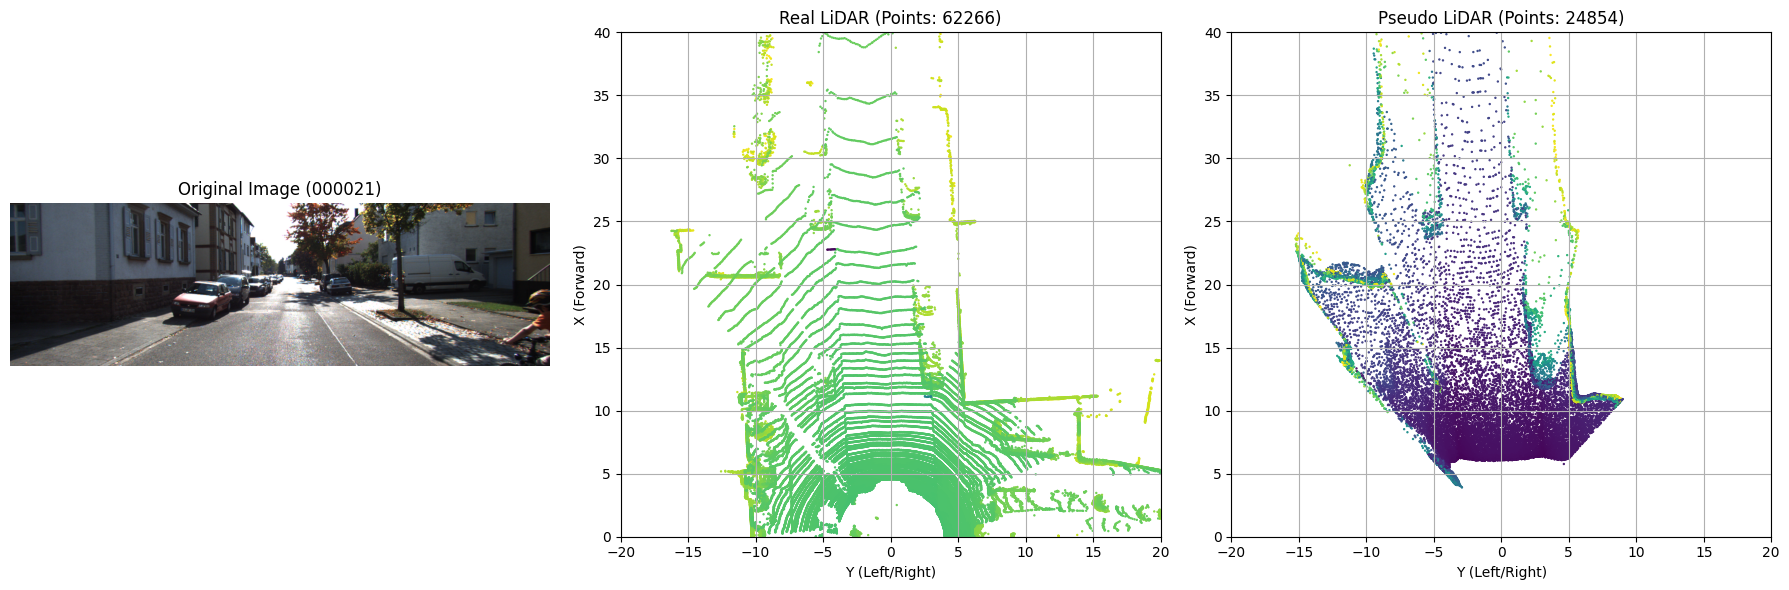

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 경로 설정
KITTI_ROOT = '/content/data/kitti/training'
IMAGE_DIR = os.path.join(KITTI_ROOT, 'image_2')
REAL_LIDAR_DIR = os.path.join(KITTI_ROOT, 'velodyne')
PSEUDO_LIDAR_DIR = os.path.join(KITTI_ROOT, 'pseudo_velodyne')

# 시각화할 인덱스
idx_str = '000021'   # 보고 싶은 프레임 번호로 변경

img_path = os.path.join(IMAGE_DIR, f'{idx_str}.png')
real_bin_path = os.path.join(REAL_LIDAR_DIR, f'{idx_str}.bin')
pseudo_bin_path = os.path.join(PSEUDO_LIDAR_DIR, f'{idx_str}.bin')

# ---------------------------
# 1) 데이터 로드 함수들
# ---------------------------
def load_velodyne(bin_path):
    points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)
    xyz = points[:, :3]
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    # 간단 ROI (전방 0~40m, 좌우 -20~20m)
    mask = (x > 0) & (x < 40) & (y > -20) & (y < 20)
    return x[mask], y[mask], z[mask]

# 원본 이미지
image = Image.open(img_path).convert('RGB')

# Real / Pseudo LiDAR
x_real, y_real, z_real = load_velodyne(real_bin_path)
x_pseudo, y_pseudo, z_pseudo = load_velodyne(pseudo_bin_path)

# ---------------------------
# 2) 시각화
# ---------------------------
plt.figure(figsize=(18, 6))

# (1) Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.axis('off')
plt.title(f'Original Image ({idx_str})')

# (2) Real LiDAR Top View
plt.subplot(1, 3, 2)
plt.scatter(y_real, x_real, s=0.5, c=z_real, cmap='viridis')
plt.xlim(-20, 20)
plt.ylim(0, 40)
plt.xlabel('Y (Left/Right)')
plt.ylabel('X (Forward)')
plt.title(f'Real LiDAR (Points: {len(x_real)})')
plt.grid(True)

# (3) Pseudo LiDAR Top View
plt.subplot(1, 3, 3)
plt.scatter(y_pseudo, x_pseudo, s=0.5, c=z_pseudo, cmap='viridis')
plt.xlim(-20, 20)
plt.ylim(0, 40)
plt.xlabel('Y (Left/Right)')
plt.ylabel('X (Forward)')
plt.title(f'Pseudo LiDAR (Points: {len(x_pseudo)})')
plt.grid(True)

plt.tight_layout()
plt.show()


### Pseudo lidar 드라이브에 저장

In [ ]:
from google.colab import drive
import os
import subprocess
import shutil

# 1. Google Drive 마운트
drive.mount('/content/drive', force_remount=True)

# 2. 경로 설정
LOCAL_PSEUDO_DIR = '/content/data/kitti/training/pseudo_velodyne'
DRIVE_SAVE_DIR = '/content/drive/MyDrive/KITTI_Data'

os.makedirs(DRIVE_SAVE_DIR, exist_ok=True)
print(f"📂 저장 경로: {DRIVE_SAVE_DIR}")

# 3. 압축
LOCAL_TAR_FILE = '/content/data/kitti/training/pseudo_velodyne.tar.gz'
print("🔐 파일 압축 중...")
os.chdir('/content/data/kitti/training')

subprocess.run(['tar', '-czf', LOCAL_TAR_FILE, 'pseudo_velodyne/'], check=True)
tar_size = os.path.getsize(LOCAL_TAR_FILE) / (1024**3)
print(f"✅ 압축 완료! 크기: {tar_size:.2f} GB")

# 4. Drive로 복사 (shutil 사용)
DRIVE_TAR_FILE = os.path.join(DRIVE_SAVE_DIR, 'pseudo_velodyne.tar.gz')
print(f"\n🚀 Google Drive로 업로드 중 ({tar_size:.2f} GB)...")

try:
    shutil.copy2(LOCAL_TAR_FILE, DRIVE_TAR_FILE)
    print("✅ Drive 업로드 성공!")

    # 검증: 파일이 실제로 Drive에 있는지 확인
    if os.path.exists(DRIVE_TAR_FILE):
        drive_size = os.path.getsize(DRIVE_TAR_FILE) / (1024**3)
        print(f"✓ 검증: Drive에 {drive_size:.2f} GB 파일 확인됨")
    else:
        print("⚠️ 경고: Drive 파일 존재하지 않음!")

except Exception as e:
    print(f"❌ 복사 실패: {e}")
    exit()

# 5. 로컬 압축 파일 삭제
print("\n🗑️  로컬 임시 파일 삭제 중...")
os.remove(LOCAL_TAR_FILE)
print("✅ 완료")


Mounted at /content/drive
📂 저장 경로: /content/drive/MyDrive/KITTI_Data
🔐 파일 압축 중...
✅ 압축 완료! 크기: 2.06 GB

🚀 Google Drive로 업로드 중 (2.06 GB)...
✅ Drive 업로드 성공!
✓ 검증: Drive에 2.06 GB 파일 확인됨

🗑️  로컬 임시 파일 삭제 중...
✅ 완료


# 나중에 다시 학습 할 때 drive에서 가져오기
(Pseudo lidar 데이터 빠름~~)

In [12]:
#from google.colab import drive
import os
import subprocess

# # 1. Drive 마운트
# drive.mount('/content/drive')

# 2. 경로 설정
DRIVE_TAR_FILE = '/content/drive/MyDrive/KITTI_Data/pseudo_velodyne.tar.gz'
LOCAL_TARGET_DIR = '/content/data/kitti/training'

# 3. 파일 존재 확인
if not os.path.exists(DRIVE_TAR_FILE):
    print("❌ Drive에 백업 파일이 없습니다!")
    exit()

tar_size = os.path.getsize(DRIVE_TAR_FILE) / (1024**3)
print(f"📦 백업 파일 확인: {tar_size:.2f} GB")

# 4. 로컬로 복사
LOCAL_TAR_FILE = '/content/pseudo_velodyne.tar.gz'
print(f"🚀 Drive → Colab 복사 중...")

subprocess.run(['cp', DRIVE_TAR_FILE, LOCAL_TAR_FILE], check=True)
print("✅ 복사 완료")

# 5. 압축 해제
print("📂 압축 해제 중...")
os.makedirs(LOCAL_TARGET_DIR, exist_ok=True)
os.chdir(LOCAL_TARGET_DIR)

subprocess.run(['tar', '-xzf', LOCAL_TAR_FILE], check=True)
print("✅ 압축 해제 완료")

# 6. 임시 tar 파일 삭제
os.remove(LOCAL_TAR_FILE)
print("🗑️  임시 파일 삭제 완료")

# 7. 최종 확인
pseudo_dir = os.path.join(LOCAL_TARGET_DIR, 'pseudo_velodyne')
file_count = len([f for f in os.listdir(pseudo_dir) if f.endswith('.bin')])
print(f"\n🎉 복원 완료!")
print(f"📁 경로: {pseudo_dir}")
print(f"📊 파일 수: {file_count}개")


📦 백업 파일 확인: 2.06 GB
🚀 Drive → Colab 복사 중...
✅ 복사 완료
📂 압축 해제 중...
✅ 압축 해제 완료
🗑️  임시 파일 삭제 완료

🎉 복원 완료!
📁 경로: /content/data/kitti/training/pseudo_velodyne
📊 파일 수: 7481개


# Student-Teacher 구조 (찐막)

## pseudo 용 Annotation 파일 생성

In [13]:
%%writefile /content/mmdetection3d/create_pseudo_annotation.py
import pickle
import os

DATA_ROOT = 'data/kitti/'
INPUT_FILE = os.path.join(DATA_ROOT, 'kitti_infos_train.pkl')
OUTPUT_FILE = os.path.join(DATA_ROOT, 'kitti_infos_train_pseudo.pkl')

print(f"📂 원본 파일 로드: {INPUT_FILE}")

# 파일 존재 확인
if not os.path.exists(INPUT_FILE):
    raise FileNotFoundError(f"❌ 원본 annotation 파일이 없습니다: {INPUT_FILE}")

with open(INPUT_FILE, 'rb') as f:
    infos = pickle.load(f)

print(f"   총 샘플 수: {len(infos['data_list'])}")

# Path 수정
modified_count = 0
for info in infos['data_list']:
    if 'lidar_points' in info and 'lidar_path' in info['lidar_points']:
        old_path = info['lidar_points']['lidar_path']
        # 'training/velodyne/000000.bin' -> 'training/pseudo_velodyne/000000.bin'
        if 'velodyne' in old_path and 'pseudo_velodyne' not in old_path:
            new_path = old_path.replace('training/velodyne', 'training/pseudo_velodyne')
            info['lidar_points']['lidar_path'] = new_path
            modified_count += 1

            if modified_count <= 3:  # 처음 3개만 출력
                print(f"   변경: {old_path} -> {new_path}")

print(f"\n✅ 총 {modified_count}개 경로 수정 완료")

# 저장
print(f"💾 저장 중: {OUTPUT_FILE}")
with open(OUTPUT_FILE, 'wb') as f:
    pickle.dump(infos, f)

print(f"✅ Pseudo annotation 파일 생성 완료!")
print(f"   파일 크기: {os.path.getsize(OUTPUT_FILE) / 1024 / 1024:.2f} MB")


Writing /content/mmdetection3d/create_pseudo_annotation.py


In [14]:
!cd /content/mmdetection3d && python create_pseudo_annotation.py


📂 원본 파일 로드: data/kitti/kitti_infos_train.pkl
   총 샘플 수: 3712

✅ 총 0개 경로 수정 완료
💾 저장 중: data/kitti/kitti_infos_train_pseudo.pkl
✅ Pseudo annotation 파일 생성 완료!
   파일 크기: 16.58 MB


# 모델 학습 코드

## 초반 학습 코드

In [ ]:
%%writefile /content/mmdetection3d/train_distillation.py
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmengine.config import Config
from mmengine.runner import load_checkpoint
from mmdet3d.registry import MODELS, DATASETS
from mmdet3d.utils import register_all_modules
from torch.utils.data import DataLoader
from mmengine.dataset import DefaultSampler, pseudo_collate
from tqdm import tqdm
import warnings


print("Python:", sys.version, flush=True)
print("Torch:", torch.__version__, flush=True)


register_all_modules()


# ==================== A100 OPTIMIZED CONFIG ====================
DATA_ROOT = 'data/kitti/'
PSEUDO_DIR = 'training/pseudo_velodyne'
REAL_DIR = 'training/velodyne'
PSEUDO_ANN_FILE = 'kitti_infos_train_pseudo.pkl'  # ✅ Pseudo용 annotation


CKPT_URL = "https://download.openmmlab.com/mmdetection3d/v1.1.0_models/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class-8963258a.pth"
CKPT_FILE = "checkpoints/mvxnet_teacher.pth"


# A100 최적화 하이퍼파라미터
BATCH_SIZE = 8
NUM_WORKERS = 8
PREFETCH_FACTOR = 3
MAX_EPOCHS = 20
INIT_LR = 2e-4
WARMUP_EPOCHS = 2
GRAD_ACCUM_STEPS = 1


# Loss weights
LOSS_WEIGHTS = {
    'detection': 1.0,
    'feat_kd': 2.0,
    'logit_kd': 1.0
}
TEMPERATURE = 2.0
FEAT_LOSS_TYPE = 'l1'


# A100 TF32 활성화
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True


print(f"🚀 A100 최적화 설정")
print(f"   TF32: {torch.backends.cuda.matmul.allow_tf32}")
print(f"   CUDNN Benchmark: {torch.backends.cudnn.benchmark}")


# ==================== HELPER FUNCTIONS ====================
def to_python_float(value):
    if isinstance(value, torch.Tensor):
        return value.item()
    return float(value)


def fix_sparse_conv3d_checkpoint(checkpoint_state_dict, model):
    fixed_state_dict = {}
    model_state_dict = model.state_dict()

    for key, value in checkpoint_state_dict.items():
        if key in model_state_dict:
            target_shape = model_state_dict[key].shape

            if 'weight' in key and value.ndim == 5 and value.shape != target_shape:
                value = value.permute(1, 2, 3, 4, 0).contiguous()

        fixed_state_dict[key] = value

    return fixed_state_dict


# ==================== SETUP ====================
os.makedirs("checkpoints", exist_ok=True)
if not os.path.exists(CKPT_FILE) or os.path.getsize(CKPT_FILE) < 100 * 1024 * 1024:
    print(f"⬇️ Teacher 모델 다운로드 중...", flush=True)
    os.system(f"wget -c {CKPT_URL} -O {CKPT_FILE}")
else:
    print("✅ 기존 Teacher 체크포인트 사용", flush=True)


config_file = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'
cfg = Config.fromfile(config_file)


# ==================== DATASET SETUP ====================
print("📦 데이터셋 준비 중...", flush=True)

# ===== Annotation 파일 확인 =====
pseudo_ann_path = os.path.join(DATA_ROOT, PSEUDO_ANN_FILE)

if not os.path.exists(pseudo_ann_path):
    print(f"\n❌ 에러: {pseudo_ann_path} 파일이 없습니다!")
    print(f"먼저 create_pseudo_annotation.py를 실행하세요.\n")
    print(f"실행 명령어:")
    print(f"  cd /content/mmdetection3d && python create_pseudo_annotation.py\n")
    raise FileNotFoundError(pseudo_ann_path)

print(f"✅ Pseudo annotation: {os.path.getsize(pseudo_ann_path) / 1024 / 1024:.2f} MB", flush=True)


base_dataset_cfg = cfg.train_dataloader.dataset.dataset
base_dataset_cfg.data_root = DATA_ROOT
base_dataset_cfg.ann_file = 'kitti_infos_train.pkl'


if not hasattr(base_dataset_cfg, 'data_prefix'):
    base_dataset_cfg.data_prefix = dict(pts='training/velodyne', img='training/image_2')


# Real dataset
real_dataset_cfg = base_dataset_cfg.copy()
real_dataset_cfg.data_prefix['pts'] = REAL_DIR
real_dataset = DATASETS.build(real_dataset_cfg)


# Pseudo dataset (수정된 annotation 사용)
pseudo_dataset_cfg = base_dataset_cfg.copy()
pseudo_dataset_cfg.data_prefix['pts'] = PSEUDO_DIR
pseudo_dataset_cfg.ann_file = PSEUDO_ANN_FILE  # ✅ Pseudo용 annotation
pseudo_dataset = DATASETS.build(pseudo_dataset_cfg)


def build_loader(dataset, batch_size, num_workers, seed=42):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=DefaultSampler(dataset, shuffle=True, seed=seed),
        batch_sampler=None,
        collate_fn=pseudo_collate,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=PREFETCH_FACTOR,
        persistent_workers=True
    )


loader_real = build_loader(real_dataset, BATCH_SIZE, NUM_WORKERS, seed=42)
loader_pseudo = build_loader(pseudo_dataset, BATCH_SIZE, NUM_WORKERS, seed=43)


print(f"✅ 데이터 로드 완료: Real({len(real_dataset)}) / Pseudo({len(pseudo_dataset)})", flush=True)
print(f"   Batch Size: {BATCH_SIZE} | Workers: {NUM_WORKERS} | Prefetch: {PREFETCH_FACTOR}", flush=True)


# GPU check
import subprocess
gpu_check = subprocess.run(['nvidia-smi'], capture_output=True)
if gpu_check.returncode != 0:
    raise RuntimeError("❌ GPU가 할당되지 않았습니다.")
if not torch.cuda.is_available():
    raise RuntimeError("❌ PyTorch에서 CUDA를 인식하지 못했습니다.")


device = 0
print(f"🤖 모델 초기화 중... (Device: cuda:{device})", flush=True)
print(f"   GPU: {torch.cuda.get_device_name(device)}", flush=True)
print(f"   Memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB", flush=True)


warnings.filterwarnings('ignore')


# ==================== MODEL LOADING ====================
print("🔧 Checkpoint 로딩 및 변환 중...", flush=True)


teacher_model = MODELS.build(cfg.model).cuda(device)


checkpoint = torch.load(CKPT_FILE, map_location='cpu')
if 'state_dict' in checkpoint:
    checkpoint_state_dict = checkpoint['state_dict']
else:
    checkpoint_state_dict = checkpoint


fixed_state_dict = fix_sparse_conv3d_checkpoint(checkpoint_state_dict, teacher_model)


teacher_model.load_state_dict(fixed_state_dict, strict=False)
teacher_model.eval()
for p in teacher_model.parameters():
    p.requires_grad = False


try:
    teacher_model = teacher_model.to(memory_format=torch.channels_last)
    print("✅ Teacher 모델: Channels Last format 적용", flush=True)
except:
    pass


print("✅ Teacher 모델 로드 완료", flush=True)


student_model = MODELS.build(cfg.model).cuda(device)
student_model.load_state_dict(fixed_state_dict, strict=False)
student_model.train()


try:
    student_model = student_model.to(memory_format=torch.channels_last)
    print("✅ Student 모델: Channels Last format 적용", flush=True)
except:
    pass


print("✅ Student 모델 로드 완료", flush=True)


# PyTorch 2.0+ compile
if hasattr(torch, 'compile') and torch.__version__ >= '2.0':
    try:
        print("🔥 PyTorch Compile 적용 중...", flush=True)
        student_model = torch.compile(student_model, mode='reduce-overhead')
        print("✅ Student 모델 Compile 완료 (속도 향상 예상)", flush=True)
    except Exception as e:
        print(f"⚠️ Compile 실패 (정상 진행): {e}", flush=True)


# Feature shape 확인
print("🔧 Feature shape 확인 중...", flush=True)
with torch.no_grad():
    sample_data = next(iter(loader_real))
    sample_data = teacher_model.data_preprocessor(sample_data, True)
    inputs = sample_data['inputs']
    data_samples = sample_data['data_samples']
    batch_input_metas = [s.metainfo for s in data_samples]
    _, sample_feats = teacher_model.extract_feat(inputs, batch_input_metas)

    if isinstance(sample_feats, (tuple, list)):
        feat_channels_list = [f.shape[1] for f in sample_feats]
    else:
        feat_channels_list = [sample_feats.shape[1]]


print(f"   Feature 채널: {feat_channels_list}", flush=True)


adaptation_layers = nn.ModuleList([
    nn.Sequential(
        nn.Conv2d(ch, ch, kernel_size=1, bias=False),
        nn.BatchNorm2d(ch),
        nn.ReLU(inplace=True)
    ) for ch in feat_channels_list
]).cuda(device)


print(f"✅ Adaptation Layers 생성 완료", flush=True)


# ==================== LOSS FUNCTIONS ====================
# ==================== LOSS FUNCTIONS ====================
def extract_features_and_logits(model, batch_inputs_dict, batch_data_samples):
    batch_input_metas = [s.metainfo for s in batch_data_samples]
    img_feats, pts_feats = model.extract_feat(batch_inputs_dict, batch_input_metas)
    outs = model.pts_bbox_head(pts_feats)
    return pts_feats, outs


def compute_feature_distillation_loss(feat_teacher, feat_student, adaptation_layers, loss_type='l1'):
    loss_feat = 0.0
    count = 0

    if isinstance(feat_teacher, (tuple, list)) and isinstance(feat_student, (tuple, list)):
        for idx, (ft, fs) in enumerate(zip(feat_teacher, feat_student)):
            if ft is None or fs is None:
                continue

            adapt_layer = adaptation_layers[min(idx, len(adaptation_layers)-1)]
            fs_adapted = adapt_layer(fs)

            if ft.shape != fs_adapted.shape:
                fs_adapted = F.interpolate(fs_adapted, size=ft.shape[2:], mode='bilinear', align_corners=False)

            if loss_type == 'l1':
                loss_feat += F.l1_loss(fs_adapted, ft.detach(), reduction='mean')
            elif loss_type == 'mse':
                loss_feat += F.mse_loss(fs_adapted, ft.detach(), reduction='mean')
            count += 1
    else:
        fs_adapted = adaptation_layers[0](feat_student)
        if loss_type == 'l1':
            loss_feat = F.l1_loss(fs_adapted, feat_teacher.detach(), reduction='mean')
        else:
            loss_feat = F.mse_loss(fs_adapted, feat_teacher.detach(), reduction='mean')
        count = 1

    return loss_feat / max(count, 1) if count > 0 else torch.tensor(0.0).cuda(device)


def compute_logit_distillation_loss(logits_teacher, logits_student, temperature=2.0):
    loss_logit = 0.0
    count = 0

    t_cls_scores = logits_teacher[0]
    s_cls_scores = logits_student[0]

    for t_score, s_score in zip(t_cls_scores, s_cls_scores):
        if t_score.shape != s_score.shape:
            continue

        t_prob = torch.sigmoid(t_score / temperature).detach()
        loss_logit += F.binary_cross_entropy_with_logits(
            s_score / temperature, t_prob, reduction='mean') * (temperature ** 2)
        count += 1

    return loss_logit / max(count, 1) if count > 0 else torch.tensor(0.0).cuda(device)
#######################################################
## compute_detection_loss 함수
#######################################################
def compute_detection_loss(model, inputs, data_samples, debug=False):
    try:
        batch_input_metas = [s.metainfo for s in data_samples]
        _, pts_feats = model.extract_feat(inputs, batch_input_metas)
        outs = model.pts_bbox_head(pts_feats)

        if isinstance(pts_feats, (list, tuple)):
            feat_device = pts_feats[0].device
        else:
            feat_device = pts_feats.device

        gt_counts = [len(sample.gt_instances_3d) for sample in data_samples]
        has_gt = any(count > 0 for count in gt_counts)

        if debug:
            print(f"[Det Loss Debug] GT counts: {gt_counts}, has_gt: {has_gt}")

            try:
                train_cfg = model.pts_bbox_head.train_cfg
                print(f"[Det Loss Debug] train_cfg type: {type(train_cfg)}")

                if hasattr(train_cfg, 'assigner'):
                    assigner = train_cfg.assigner
                    print(f"[Det Loss Debug] Assigner type: {type(assigner)}")
                    if hasattr(assigner, 'pos_iou_thr'):
                        print(f"    pos_iou_thr: {assigner.pos_iou_thr}")
                        print(f"    neg_iou_thr: {assigner.neg_iou_thr}")
                        print(f"    min_pos_iou: {assigner.min_pos_iou}")
            except Exception as e:
                print(f"[Det Loss Debug] Config access error: {e}")

            print(f"[Det Loss Debug] Predictions:")
            print(f"    cls_scores: {len(outs[0])} levels")
            print(f"    bbox_preds: {len(outs[1])} levels")

        if not has_gt:
            return torch.tensor(0.0, device=feat_device, dtype=torch.float32)

        losses_dict = model.pts_bbox_head.loss_by_feat(
            cls_scores=outs[0],
            bbox_preds=outs[1],
            dir_cls_preds=outs[2] if len(outs) > 2 else None,
            batch_gt_instances_3d=[sample.gt_instances_3d for sample in data_samples],
            batch_input_metas=batch_input_metas
        )

        if debug:
            print(f"[Det Loss Debug] Returned losses:")
            for key, value in losses_dict.items():
                # List 처리
                if isinstance(value, list):
                    val_sum = sum(v.item() if isinstance(v, torch.Tensor) else 0 for v in value)
                    print(f"    {key}: {value} → sum={val_sum:.4f}")
                elif isinstance(value, torch.Tensor):
                    val = value.item() if value.numel() == 1 else value.mean().item()
                    print(f"    {key}: {val:.6f}")
                else:
                    print(f"    {key}: {value}")

        # ===== List 처리 추가 =====
        total_loss = torch.tensor(0.0, device=feat_device, dtype=torch.float32)
        for key, value in losses_dict.items():
            if isinstance(value, list):
                # List인 경우: 각 element를 더함
                for v in value:
                    if isinstance(v, torch.Tensor) and v.numel() > 0:
                        total_loss = total_loss + v
            elif isinstance(value, torch.Tensor) and value.numel() > 0:
                # Tensor인 경우: 바로 더함
                total_loss = total_loss + value

        if debug:
            print(f"[Det Loss Debug] Total Det Loss: {total_loss.item():.6f}\n")

        return total_loss

    except Exception as e:
        if debug:
            print(f"[Det Loss Error] {e}")
            import traceback
            traceback.print_exc()
        return torch.tensor(0.0, device='cuda:0', dtype=torch.float32)



# ==================== OPTIMIZER ====================
print("⚙️ Optimizer 설정 중...", flush=True)
trainable_params = list(student_model.parameters()) + list(adaptation_layers.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=INIT_LR, weight_decay=0.01, betas=(0.9, 0.999))


total_steps = MAX_EPOCHS * len(loader_real) // GRAD_ACCUM_STEPS
warmup_steps = WARMUP_EPOCHS * len(loader_real) // GRAD_ACCUM_STEPS


def get_lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.141592653589793))))


scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)


print(f"   총 파라미터: {sum(p.numel() for p in trainable_params):,}", flush=True)
print(f"   Total steps: {total_steps} | Warmup steps: {warmup_steps}", flush=True)


# ==================== TRAINING ====================
print(f"\n{'='*70}")
print("🚀 A100 최적화 Distillation 학습 시작")
print(f"   Batch Size: {BATCH_SIZE} (Effective: {BATCH_SIZE * GRAD_ACCUM_STEPS})")
print(f"   Workers: {NUM_WORKERS} | Prefetch: {PREFETCH_FACTOR}")
print(f"   TF32: Enabled | CUDNN Benchmark: Enabled")
print(f"   Loss Weights: Det={LOSS_WEIGHTS['detection']}, Feat={LOSS_WEIGHTS['feat_kd']}, Logit={LOSS_WEIGHTS['logit_kd']}")
print(f"{'='*70}\n", flush=True)


os.makedirs('work_dirs', exist_ok=True)


history = {'det_loss': [], 'feat_kd_loss': [], 'logit_kd_loss': [], 'total_loss': [], 'lr': []}
best_loss = float('inf')


import time


for epoch in range(MAX_EPOCHS):
    student_model.train()
    adaptation_layers.train()

    epoch_det_loss = 0.0
    epoch_feat_kd_loss = 0.0
    epoch_logit_kd_loss = 0.0
    epoch_total_loss = 0.0
    num_batches = 0

    epoch_start_time = time.time()

    pbar = tqdm(
        zip(loader_real, loader_pseudo),
        total=min(len(loader_real), len(loader_pseudo)),
        desc=f"Epoch {epoch+1}/{MAX_EPOCHS}",
        ncols=110,
        position=0,
        leave=True,
        file=sys.stdout
    )

    optimizer.zero_grad()

    for i, (data_real, data_pseudo) in enumerate(pbar):
        try:
            # ===== 디버깅 (첫 batch만) =====
            if epoch == 0 and i == 0:
                print(f"\n{'='*70}")
                print("🔍 GT 확인 - Epoch 1, Batch 0")
                print(f"{'='*70}\n")

            # Preprocess
            data_real = teacher_model.data_preprocessor(data_real, True)
            inputs_real = data_real['inputs']
            data_samples_real = data_real['data_samples']

            data_pseudo = student_model.data_preprocessor(data_pseudo, True)
            inputs_pseudo = data_pseudo['inputs']
            data_samples_pseudo = data_pseudo['data_samples']

            # GT 확인 (첫 batch만)
            if epoch == 0 and i == 0:
                print("Real Data GT:")
                for idx in range(min(2, len(data_samples_real))):
                    print(f"  Sample {idx}: {len(data_samples_real[idx].gt_instances_3d)} GTs")

                print("\nPseudo Data GT:")
                for idx in range(min(2, len(data_samples_pseudo))):
                    gt_count = len(data_samples_pseudo[idx].gt_instances_3d)
                    print(f"  Sample {idx}: {gt_count} GTs")
                    if gt_count == 0:
                        print(f"    ❌ GT 없음!")
                print()

            # Forward
            with torch.no_grad():
                feat_teacher, logits_teacher = extract_features_and_logits(
                    teacher_model, inputs_real, data_samples_real)

            feat_student, logits_student = extract_features_and_logits(
                student_model, inputs_pseudo, data_samples_pseudo)

            # Compute losses
            loss_det = compute_detection_loss(
                student_model, inputs_pseudo, data_samples_pseudo,
                debug=(epoch == 0 and i == 0)
            )
            loss_feat_kd = compute_feature_distillation_loss(
                feat_teacher, feat_student, adaptation_layers, loss_type=FEAT_LOSS_TYPE)
            loss_logit_kd = compute_logit_distillation_loss(
                logits_teacher, logits_student, temperature=TEMPERATURE)

            # Total loss
            total_loss = (
                LOSS_WEIGHTS['detection'] * loss_det +
                LOSS_WEIGHTS['feat_kd'] * loss_feat_kd +
                LOSS_WEIGHTS['logit_kd'] * loss_logit_kd
            ) / GRAD_ACCUM_STEPS

            # Backward
            total_loss.backward()

            # Optimizer step
            if (i + 1) % GRAD_ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=35.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            # Logging
            epoch_det_loss += to_python_float(loss_det)
            epoch_feat_kd_loss += to_python_float(loss_feat_kd)
            epoch_logit_kd_loss += to_python_float(loss_logit_kd)
            epoch_total_loss += to_python_float(total_loss) * GRAD_ACCUM_STEPS
            num_batches += 1

            # Update progress bar
            if i % 10 == 0:
                pbar.set_postfix({
                    'Det': f'{to_python_float(loss_det):.3f}',
                    'Feat': f'{to_python_float(loss_feat_kd):.3f}',
                    'Logit': f'{to_python_float(loss_logit_kd):.3f}',
                    'Total': f'{to_python_float(total_loss) * GRAD_ACCUM_STEPS:.3f}',
                    'it/s': f'{pbar.format_dict["rate"]:.2f}' if pbar.format_dict.get("rate") else '0.00'
                }, refresh=True)

            # Memory cleanup
            if i % 50 == 0:
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"\n❌ Batch {i}: {str(e)[:100]}", flush=True)
            continue

    pbar.close()

    epoch_time = time.time() - epoch_start_time

    # Epoch stats
    if num_batches > 0:
        avg_det = epoch_det_loss / num_batches
        avg_feat_kd = epoch_feat_kd_loss / num_batches
        avg_logit_kd = epoch_logit_kd_loss / num_batches
        avg_total = epoch_total_loss / num_batches

        history['det_loss'].append(avg_det)
        history['feat_kd_loss'].append(avg_feat_kd)
        history['logit_kd_loss'].append(avg_logit_kd)
        history['total_loss'].append(avg_total)
        history['lr'].append(scheduler.get_last_lr()[0])

        samples_per_sec = (num_batches * BATCH_SIZE) / epoch_time

        print(f"\n{'='*70}")
        print(f"📊 Epoch {epoch+1}/{MAX_EPOCHS} - {epoch_time/60:.1f}min ({samples_per_sec:.1f} samples/s)")
        print(f"   Det: {avg_det:.4f} | Feat: {avg_feat_kd:.4f} | Logit: {avg_logit_kd:.4f} | Total: {avg_total:.4f}")
        print(f"   LR: {scheduler.get_last_lr()[0]:.2e}")
        print(f"{'='*70}\n", flush=True)

        # Save best
        if avg_total < best_loss:
            best_loss = avg_total
            torch.save({
                'epoch': epoch + 1,
                'student_state_dict': student_model.state_dict(),
                'adaptation_layers_state_dict': adaptation_layers.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total,
                'history': history
            }, 'work_dirs/mvxnet_student_best.pth')
            print(f"💾 Best 저장 (Loss: {best_loss:.4f})\n", flush=True)

        # Periodic save
        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': epoch + 1,
                'student_state_dict': student_model.state_dict(),
                'adaptation_layers_state_dict': adaptation_layers.state_dict(),
                'loss': avg_total
            }, f'work_dirs/mvxnet_student_epoch{epoch+1}.pth')


# Final save
if num_batches > 0:
    torch.save({
        'epoch': MAX_EPOCHS,
        'student_state_dict': student_model.state_dict(),
        'adaptation_layers_state_dict': adaptation_layers.state_dict(),
        'loss': avg_total,
        'history': history,
        'config': LOSS_WEIGHTS
    }, 'work_dirs/mvxnet_student_final.pth')


print(f"\n{'='*70}")
print("🎉 학습 완료!")
print(f"   Best Loss: {best_loss:.4f}")
print(f"{'='*70}", flush=True)


Writing /content/mmdetection3d/train_distillation.py


In [ ]:
import subprocess
import os

print("="*70)
print("🚀 Pseudo LiDAR Distillation 학습 시작")
print("="*70 + "\n")

# ===== Step 1: Annotation 생성 =====
print("Step 1: Pseudo Annotation 파일 생성")
print("-"*70)

result = subprocess.run(
    ['/content/conda/envs/openmmlab/bin/python', '/content/mmdetection3d/create_pseudo_annotation.py'],
    cwd='/content/mmdetection3d',
    capture_output=True,
    text=True
)

print(result.stdout)
if result.returncode != 0:
    print("❌ Annotation 생성 실패:")
    print(result.stderr)
    exit(1)

# 파일 확인
anno_file = '/content/mmdetection3d/data/kitti/kitti_infos_train_pseudo.pkl'
if not os.path.exists(anno_file):
    print(f"❌ 파일이 생성되지 않았습니다: {anno_file}")
    exit(1)

print(f"✅ Annotation 파일 확인 완료: {os.path.getsize(anno_file) / 1024 / 1024:.2f} MB\n")

# ===== Step 2: 학습 시작 =====
print("="*70)
print("Step 2: Distillation 학습")
print("="*70 + "\n")

env = os.environ.copy()
env['PYTHONPATH'] = '/content/mmdetection3d:' + env.get('PYTHONPATH', '')

proc = subprocess.Popen(
    ['/content/conda/envs/openmmlab/bin/python', '-u', '/content/mmdetection3d/train_distillation.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    cwd='/content/mmdetection3d',
    env=env
)

for line in proc.stdout:
    print(line, end='', flush=True)

proc.wait()

if proc.returncode == 0:
    print("\n" + "="*70)
    print("✅ 전체 학습 완료!")
    print("="*70)
else:
    print(f"\n❌ 에러 발생 (exit code: {proc.returncode})")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch 11/20:  45%|▍| 210/464 [05:24<06:36,  1.56s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  45%|▍| 211/464 [05:24<06:24,  1.52s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  46%|▍| 212/464 [05:25<06:26,  1.53s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  46%|▍| 213/464 [05:27<06:24,  1.53s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  46%|▍| 214/464 [05:28<06:16,  1.51s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  46%|▍| 215/464 [05:30<06:25,  1.55s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  47%|▍| 216/464 [05:31<06:12,  1.50s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  47%|▍| 217/464 [05:33<05:55,  1.44s/it, Det=1.316, Feat=0.030, Logit=0.294, Total=1.669, it/s=0.
Epoch 11/20:  47%|▍| 218/464 [05:34<06:03,  1.48s/it, Det=1.316, Feat=0.030,

## 이어서 학습해보기

In [17]:
%%writefile /content/mmdetection3d/create_pseudo_annotation.py
import os
import pickle
import copy
from pathlib import Path

print("=" * 70)
print("🔧 Pseudo LiDAR Annotation 생성")
print("=" * 70)

# 경로 설정
DATA_ROOT = 'data/kitti/'
REAL_ANN_FILE = os.path.join(DATA_ROOT, 'kitti_infos_train.pkl')
PSEUDO_ANN_FILE = os.path.join(DATA_ROOT, 'kitti_infos_train_pseudo.pkl')
PSEUDO_DIR = os.path.join(DATA_ROOT, 'training/pseudo_velodyne')

# Real annotation 로드
print(f"\n1️⃣ Real annotation 로드 중...")
print(f"   파일: {REAL_ANN_FILE}")

if not os.path.exists(REAL_ANN_FILE):
    raise FileNotFoundError(f"Real annotation 파일이 없습니다: {REAL_ANN_FILE}")

# ✅ NumPy 1.x 호환성 확보
import numpy as np
print(f"   NumPy 버전: {np.__version__}")

with open(REAL_ANN_FILE, 'rb') as f:
    real_data = pickle.load(f, encoding='latin1')

print(f"✅ Real annotation 로드 완료")
print(f"   샘플 수: {len(real_data['data_list']) if 'data_list' in real_data else len(real_data)}")

# Pseudo annotation 생성
print(f"\n2️⃣ Pseudo annotation 생성 중...")

if isinstance(real_data, dict) and 'data_list' in real_data:
    # MMDet3D v1.4.0 형식
    pseudo_data = copy.deepcopy(real_data)
    data_list = pseudo_data['data_list']

    print(f"   형식: MMDet3D v1.4.0 (data_list)")

    # LiDAR 경로를 pseudo_velodyne으로 변경
    updated_count = 0
    for idx, data_info in enumerate(data_list):
        if 'lidar_points' in data_info:
            lidar_path = data_info['lidar_points']['lidar_path']

            # training/velodyne → training/pseudo_velodyne
            if 'training/velodyne' in lidar_path:
                new_path = lidar_path.replace('training/velodyne', 'training/pseudo_velodyne')
                data_info['lidar_points']['lidar_path'] = new_path
                updated_count += 1

        if (idx + 1) % 1000 == 0:
            print(f"   처리 중: {idx + 1}/{len(data_list)}")

    print(f"✅ {updated_count}/{len(data_list)} 샘플 경로 업데이트 완료")

else:
    # 구버전 형식
    print(f"   형식: Legacy (list)")
    pseudo_data = copy.deepcopy(real_data)

    for idx, data_info in enumerate(pseudo_data):
        if 'point_cloud' in data_info:
            velodyne_path = data_info['point_cloud']['velodyne_path']
            new_path = velodyne_path.replace('training/velodyne', 'training/pseudo_velodyne')
            data_info['point_cloud']['velodyne_path'] = new_path

# ✅ NumPy 1.x 호환 저장 (protocol=4)
print(f"\n3️⃣ Pseudo annotation 저장 중...")
print(f"   파일: {PSEUDO_ANN_FILE}")

with open(PSEUDO_ANN_FILE, 'wb') as f:
    pickle.dump(pseudo_data, f, protocol=4)  # protocol=4: NumPy 1.x 호환

file_size = os.path.getsize(PSEUDO_ANN_FILE) / 1024 / 1024
print(f"✅ 저장 완료: {file_size:.2f} MB")

# Pseudo LiDAR 파일 확인
print(f"\n4️⃣ Pseudo LiDAR 파일 확인...")
print(f"   디렉토리: {PSEUDO_DIR}")

if not os.path.exists(PSEUDO_DIR):
    print(f"❌ 경고: Pseudo LiDAR 디렉토리가 없습니다!")
    print(f"   생성 필요: {PSEUDO_DIR}")
else:
    bin_files = list(Path(PSEUDO_DIR).glob('*.bin'))
    print(f"✅ Pseudo LiDAR 파일: {len(bin_files)}개")

print(f"\n{'='*70}")
print("✅ Pseudo Annotation 생성 완료!")
print(f"{'='*70}\n")


Overwriting /content/mmdetection3d/create_pseudo_annotation.py


In [18]:
!cd /content/mmdetection3d && \
 export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH && \
 export NUMBA_DISABLE_CUDA=1 && \
 /content/conda/envs/openmmlab/bin/python create_pseudo_annotation.py


🔧 Pseudo LiDAR Annotation 생성

1️⃣ Real annotation 로드 중...
   파일: data/kitti/kitti_infos_train.pkl
   NumPy 버전: 1.24.4
✅ Real annotation 로드 완료
   샘플 수: 3712

2️⃣ Pseudo annotation 생성 중...
   형식: MMDet3D v1.4.0 (data_list)
   처리 중: 1000/3712
   처리 중: 2000/3712
   처리 중: 3000/3712
✅ 0/3712 샘플 경로 업데이트 완료

3️⃣ Pseudo annotation 저장 중...
   파일: data/kitti/kitti_infos_train_pseudo.pkl
✅ 저장 완료: 16.58 MB

4️⃣ Pseudo LiDAR 파일 확인...
   디렉토리: data/kitti/training/pseudo_velodyne
✅ Pseudo LiDAR 파일: 7481개

✅ Pseudo Annotation 생성 완료!



In [1]:
%%writefile /content/mmdetection3d/train_distillation_resume.py
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from mmengine.config import Config
from mmengine.runner import load_checkpoint
from mmdet3d.registry import MODELS, DATASETS
from mmdet3d.utils import register_all_modules
from torch.utils.data import DataLoader
from mmengine.dataset import DefaultSampler, pseudo_collate
from tqdm import tqdm
import warnings

print("Python:", sys.version, flush=True)
print("Torch:", torch.__version__, flush=True)

register_all_modules()

# ==================== A100 80GB 최적화 설정 ====================
DATA_ROOT = 'data/kitti/'
PSEUDO_DIR = 'training/pseudo_velodyne'
REAL_DIR = 'training/velodyne'
PSEUDO_ANN_FILE = 'kitti_infos_train_pseudo.pkl'

CKPT_URL = "https://download.openmmlab.com/mmdetection3d/v1.1.0_models/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class-8963258a.pth"
CKPT_FILE = "checkpoints/mvxnet_teacher.pth"

# ✅ 30 epoch 가중치 우선 탐색
RESUME_CKPT = None
possible_ckpts = [
    'work_dirs/mvxnet_student_epoch30.pth'
]
for ckpt_path in possible_ckpts:
    if os.path.exists(ckpt_path):
        RESUME_CKPT = ckpt_path
        print(f"✅ Resume checkpoint 발견: {RESUME_CKPT}", flush=True)
        break

# A100 80GB 최적화
BATCH_SIZE = 8
NUM_WORKERS = 8
PREFETCH_FACTOR = 4
MAX_EPOCHS = 50  # 30 → 80 (50 epoch 추가)
INIT_LR = 3e-5   # 5e-5 → 3e-5 (loss weight 변경 시 안정성)
WARMUP_EPOCHS = 2  # 3 → 2 (짧게)
GRAD_ACCUM_STEPS = 1

# ✅ Class 학습 강화된 Loss 가중치
LOSS_WEIGHTS = {
    'detection': 2.5,   # 3.0 → 2.5 (Detection 약간 낮춤)
    'feat_kd': 2.0,     # 1.5 → 2.0 (Feature quality)
    'logit_kd': 2.5     # 1.5 → 2.5 (✅ Classification 강화)
}
TEMPERATURE = 4.0      # 3.0 → 4.0 (✅ Soft target 강화)
FEAT_LOSS_TYPE = 'mse'

# AMP 비활성화
USE_AMP = False

# A100 최적화
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False

print(f"\n{'='*70}")
print(f"🚀 A100 80GB 최적화 설정 (Class 학습 강화)")
print(f"{'='*70}")
print(f"   Batch Size: {BATCH_SIZE} × {GRAD_ACCUM_STEPS} (Effective: {BATCH_SIZE * GRAD_ACCUM_STEPS})")
print(f"   Workers: {NUM_WORKERS} | Prefetch: {PREFETCH_FACTOR}")
print(f"   Learning Rate: {INIT_LR:.2e} (안정화)")
print(f"   Loss Weights: Det={LOSS_WEIGHTS['detection']}, Feat={LOSS_WEIGHTS['feat_kd']}, Logit={LOSS_WEIGHTS['logit_kd']}")
print(f"   Temperature: {TEMPERATURE} (Soft label 강화)")
print(f"   AMP: {USE_AMP}")
print(f"   Resume from: {RESUME_CKPT if RESUME_CKPT else 'From scratch'}")
print(f"{'='*70}\n", flush=True)

# ==================== HELPER FUNCTIONS ====================
def to_python_float(value):
    if isinstance(value, torch.Tensor):
        return value.item()
    return float(value)

def fix_sparse_conv3d_checkpoint(checkpoint_state_dict, model):
    fixed_state_dict = {}
    model_state_dict = model.state_dict()

    for key, value in checkpoint_state_dict.items():
        if key in model_state_dict:
            target_shape = model_state_dict[key].shape

            if 'weight' in key and value.ndim == 5 and value.shape != target_shape:
                value = value.permute(1, 2, 3, 4, 0).contiguous()

        fixed_state_dict[key] = value

    return fixed_state_dict

# ==================== SETUP ====================
os.makedirs("checkpoints", exist_ok=True)
if not os.path.exists(CKPT_FILE) or os.path.getsize(CKPT_FILE) < 100 * 1024 * 1024:
    print(f"⬇️ Teacher 모델 다운로드 중...", flush=True)
    os.system(f"wget -c {CKPT_URL} -O {CKPT_FILE}")
else:
    print("✅ 기존 Teacher 체크포인트 사용", flush=True)

config_file = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'
cfg = Config.fromfile(config_file)

# ==================== DATASET SETUP ====================
print("📦 데이터셋 준비 중...", flush=True)

pseudo_ann_path = os.path.join(DATA_ROOT, PSEUDO_ANN_FILE)
if not os.path.exists(pseudo_ann_path):
    print(f"\n❌ 에러: {pseudo_ann_path} 파일이 없습니다!")
    raise FileNotFoundError(pseudo_ann_path)

print(f"✅ Pseudo annotation: {os.path.getsize(pseudo_ann_path) / 1024 / 1024:.2f} MB", flush=True)

base_dataset_cfg = cfg.train_dataloader.dataset.dataset
base_dataset_cfg.data_root = DATA_ROOT
base_dataset_cfg.ann_file = 'kitti_infos_train.pkl'

if not hasattr(base_dataset_cfg, 'data_prefix'):
    base_dataset_cfg.data_prefix = dict(pts='training/velodyne', img='training/image_2')

# Data Augmentation
if hasattr(base_dataset_cfg, 'pipeline'):
    for transform in base_dataset_cfg.pipeline:
        if transform['type'] == 'RandomFlip3D':
            transform['flip_ratio_bev_horizontal'] = 0.5
            transform['flip_ratio_bev_vertical'] = 0.5

# Real dataset
real_dataset_cfg = base_dataset_cfg.copy()
real_dataset_cfg.data_prefix['pts'] = REAL_DIR
real_dataset = DATASETS.build(real_dataset_cfg)

# Pseudo dataset
pseudo_dataset_cfg = base_dataset_cfg.copy()
pseudo_dataset_cfg.data_prefix['pts'] = PSEUDO_DIR
pseudo_dataset_cfg.ann_file = PSEUDO_ANN_FILE
pseudo_dataset = DATASETS.build(pseudo_dataset_cfg)

def build_loader(dataset, batch_size, num_workers, seed=42):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=DefaultSampler(dataset, shuffle=True, seed=seed),
        batch_sampler=None,
        collate_fn=pseudo_collate,
        num_workers=num_workers,
        pin_memory=True,
        prefetch_factor=PREFETCH_FACTOR,
        persistent_workers=True
    )

loader_real = build_loader(real_dataset, BATCH_SIZE, NUM_WORKERS, seed=42)
loader_pseudo = build_loader(pseudo_dataset, BATCH_SIZE, NUM_WORKERS, seed=43)

print(f"✅ 데이터 로드 완료: Real({len(real_dataset)}) / Pseudo({len(pseudo_dataset)})", flush=True)
print(f"   Batch Size: {BATCH_SIZE} | Workers: {NUM_WORKERS} | Prefetch: {PREFETCH_FACTOR}", flush=True)

# GPU check
import subprocess
gpu_check = subprocess.run(['nvidia-smi'], capture_output=True)
if gpu_check.returncode != 0:
    raise RuntimeError("❌ GPU가 할당되지 않았습니다.")
if not torch.cuda.is_available():
    raise RuntimeError("❌ PyTorch에서 CUDA를 인식하지 못했습니다.")

device = 0
print(f"🤖 모델 초기화 중... (Device: cuda:{device})", flush=True)
print(f"   GPU: {torch.cuda.get_device_name(device)}", flush=True)
print(f"   Memory: {torch.cuda.get_device_properties(device).total_memory / 1e9:.1f} GB", flush=True)

warnings.filterwarnings('ignore')

# ==================== MODEL LOADING ====================
print("🔧 Checkpoint 로딩 및 변환 중...", flush=True)

teacher_model = MODELS.build(cfg.model).cuda(device)
checkpoint = torch.load(CKPT_FILE, map_location='cpu')
if 'state_dict' in checkpoint:
    checkpoint_state_dict = checkpoint['state_dict']
else:
    checkpoint_state_dict = checkpoint

fixed_state_dict = fix_sparse_conv3d_checkpoint(checkpoint_state_dict, teacher_model)
teacher_model.load_state_dict(fixed_state_dict, strict=False)
teacher_model.eval()
for p in teacher_model.parameters():
    p.requires_grad = False

print("✅ Teacher 모델 로드 완료", flush=True)

student_model = MODELS.build(cfg.model).cuda(device)

# Resume checkpoint 로딩
start_epoch = 0
if RESUME_CKPT and os.path.exists(RESUME_CKPT):
    print(f"\n{'='*70}")
    print(f"📂 Resume Checkpoint 로딩: {RESUME_CKPT}")
    print(f"{'='*70}\n", flush=True)

    resume_checkpoint = torch.load(RESUME_CKPT, map_location='cpu')

    if 'student_state_dict' in resume_checkpoint:
        student_model.load_state_dict(resume_checkpoint['student_state_dict'], strict=False)
        print(f"✅ Student 모델 가중치 로드 완료", flush=True)

    if 'epoch' in resume_checkpoint:
        start_epoch = resume_checkpoint['epoch']
        print(f"✅ 이전 Epoch: {start_epoch}", flush=True)

    if 'loss' in resume_checkpoint:
        print(f"✅ 이전 Loss: {resume_checkpoint['loss']:.4f}", flush=True)

    print(f"\n{'='*70}")
    print(f"🔄 학습 재개: Epoch {start_epoch+1} → {start_epoch + MAX_EPOCHS}")
    print(f"⚠️ Loss Weight 변경: Logit KD 강화 (Class 학습)")
    print(f"{'='*70}\n", flush=True)
else:
    print("⚠️ Resume checkpoint 없음 - 처음부터 학습 시작", flush=True)
    student_model.load_state_dict(fixed_state_dict, strict=False)

student_model.train()

print("✅ Student 모델 로드 완료", flush=True)

# Feature shape 확인
print("🔧 Feature shape 확인 중...", flush=True)
with torch.no_grad():
    sample_data = next(iter(loader_real))
    sample_data = teacher_model.data_preprocessor(sample_data, True)
    inputs = sample_data['inputs']
    data_samples = sample_data['data_samples']
    batch_input_metas = [s.metainfo for s in data_samples]
    _, sample_feats = teacher_model.extract_feat(inputs, batch_input_metas)

    if isinstance(sample_feats, (tuple, list)):
        feat_channels_list = [f.shape[1] for f in sample_feats]
    else:
        feat_channels_list = [sample_feats.shape[1]]

print(f"   Feature 채널: {feat_channels_list}", flush=True)

adaptation_layers = nn.ModuleList([
    nn.Sequential(
        nn.Conv2d(ch, ch, kernel_size=1, bias=False),
        nn.BatchNorm2d(ch),
        nn.ReLU(inplace=True)
    ) for ch in feat_channels_list
]).cuda(device)

# Adaptation layers Resume
if RESUME_CKPT and os.path.exists(RESUME_CKPT):
    resume_checkpoint = torch.load(RESUME_CKPT, map_location='cpu')
    if 'adaptation_layers_state_dict' in resume_checkpoint:
        adaptation_layers.load_state_dict(resume_checkpoint['adaptation_layers_state_dict'], strict=False)
        print(f"✅ Adaptation Layers 가중치 로드 완료", flush=True)

print(f"✅ Adaptation Layers 준비 완료", flush=True)

# ==================== LOSS FUNCTIONS ====================
def extract_features_and_logits(model, batch_inputs_dict, batch_data_samples):
    batch_input_metas = [s.metainfo for s in batch_data_samples]
    img_feats, pts_feats = model.extract_feat(batch_inputs_dict, batch_input_metas)
    outs = model.pts_bbox_head(pts_feats)
    return pts_feats, outs

def compute_feature_distillation_loss(feat_teacher, feat_student, adaptation_layers, loss_type='mse'):
    loss_feat = 0.0
    count = 0

    if isinstance(feat_teacher, (tuple, list)) and isinstance(feat_student, (tuple, list)):
        for idx, (ft, fs) in enumerate(zip(feat_teacher, feat_student)):
            if ft is None or fs is None:
                continue

            adapt_layer = adaptation_layers[min(idx, len(adaptation_layers)-1)]
            fs_adapted = adapt_layer(fs)

            if ft.shape != fs_adapted.shape:
                fs_adapted = F.interpolate(fs_adapted, size=ft.shape[2:], mode='bilinear', align_corners=False)

            if loss_type == 'l1':
                loss_feat += F.l1_loss(fs_adapted, ft.detach(), reduction='mean')
            elif loss_type == 'mse':
                loss_feat += F.mse_loss(fs_adapted, ft.detach(), reduction='mean')
            count += 1
    else:
        fs_adapted = adaptation_layers[0](feat_student)
        if loss_type == 'l1':
            loss_feat = F.l1_loss(fs_adapted, feat_teacher.detach(), reduction='mean')
        else:
            loss_feat = F.mse_loss(fs_adapted, feat_teacher.detach(), reduction='mean')
        count = 1

    return loss_feat / max(count, 1) if count > 0 else torch.tensor(0.0).cuda(device)

def compute_logit_distillation_loss(logits_teacher, logits_student, temperature=4.0):
    loss_logit = 0.0
    count = 0

    t_cls_scores = logits_teacher[0]
    s_cls_scores = logits_student[0]

    for t_score, s_score in zip(t_cls_scores, s_cls_scores):
        if t_score.shape != s_score.shape:
            continue

        t_prob = torch.sigmoid(t_score / temperature).detach()
        loss_logit += F.binary_cross_entropy_with_logits(
            s_score / temperature, t_prob, reduction='mean') * (temperature ** 2)
        count += 1

    return loss_logit / max(count, 1) if count > 0 else torch.tensor(0.0).cuda(device)

def compute_detection_loss(model, inputs, data_samples):
    try:
        batch_input_metas = [s.metainfo for s in data_samples]
        _, pts_feats = model.extract_feat(inputs, batch_input_metas)
        outs = model.pts_bbox_head(pts_feats)

        if isinstance(pts_feats, (list, tuple)):
            feat_device = pts_feats[0].device
        else:
            feat_device = pts_feats.device

        gt_counts = [len(sample.gt_instances_3d) for sample in data_samples]
        has_gt = any(count > 0 for count in gt_counts)

        if not has_gt:
            return torch.tensor(0.0, device=feat_device, dtype=torch.float32)

        losses_dict = model.pts_bbox_head.loss_by_feat(
            cls_scores=outs[0],
            bbox_preds=outs[1],
            dir_cls_preds=outs[2] if len(outs) > 2 else None,
            batch_gt_instances_3d=[sample.gt_instances_3d for sample in data_samples],
            batch_input_metas=batch_input_metas
        )

        # ✅ Classification loss 강화
        CLASS_WEIGHTS = {
            'loss_cls': 1.5,      # Classification 1.5배
            'loss_bbox': 1.0,
            'loss_dir': 1.0
        }

        total_loss = torch.tensor(0.0, device=feat_device, dtype=torch.float32)
        for key, value in losses_dict.items():
            weight = CLASS_WEIGHTS.get(key, 1.0)

            if isinstance(value, list):
                for v in value:
                    if isinstance(v, torch.Tensor) and v.numel() > 0:
                        total_loss = total_loss + v * weight
            elif isinstance(value, torch.Tensor) and value.numel() > 0:
                total_loss = total_loss + value * weight

        return total_loss

    except Exception as e:
        return torch.tensor(0.0, device='cuda:0', dtype=torch.float32)

# ==================== OPTIMIZER ====================
print("⚙️ Optimizer 설정 중...", flush=True)
trainable_params = list(student_model.parameters()) + list(adaptation_layers.parameters())
optimizer = torch.optim.AdamW(trainable_params, lr=INIT_LR, weight_decay=0.01, betas=(0.9, 0.999))

# ⚠️ Loss weight 변경 시 optimizer state는 reset (안정성)
print(f"⚠️ Loss weight 변경으로 Optimizer state 초기화", flush=True)

total_steps = MAX_EPOCHS * len(loader_real) // GRAD_ACCUM_STEPS
warmup_steps = WARMUP_EPOCHS * len(loader_real) // GRAD_ACCUM_STEPS

def get_lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return max(0.0, 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.141592653589793))))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)

print(f"   총 파라미터: {sum(p.numel() for p in trainable_params):,}", flush=True)
print(f"   Total steps: {total_steps} | Warmup steps: {warmup_steps}", flush=True)

# ==================== TRAINING ====================
print(f"\n{'='*70}")
print("🚀 A100 최적화 Distillation 학습 시작 (Class 학습 강화)")
print(f"   Effective Batch: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"   AMP: {USE_AMP}")
print(f"   Epoch: {start_epoch + 1} → {start_epoch + MAX_EPOCHS}")
print(f"{'='*70}\n", flush=True)

os.makedirs('work_dirs', exist_ok=True)

history = {'det_loss': [], 'feat_kd_loss': [], 'logit_kd_loss': [], 'total_loss': [], 'lr': []}
best_loss = float('inf')

import time

for epoch in range(MAX_EPOCHS):
    student_model.train()
    adaptation_layers.train()

    epoch_det_loss = 0.0
    epoch_feat_kd_loss = 0.0
    epoch_logit_kd_loss = 0.0
    epoch_total_loss = 0.0
    num_batches = 0

    epoch_start_time = time.time()

    pbar = tqdm(
        zip(loader_real, loader_pseudo),
        total=min(len(loader_real), len(loader_pseudo)),
        desc=f"Epoch {start_epoch + epoch+1:2d}/{start_epoch + MAX_EPOCHS}",
        bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]',
        ncols=100,
        leave=True,
        file=sys.stdout
    )

    optimizer.zero_grad()

    for i, (data_real, data_pseudo) in enumerate(pbar):
        try:
            data_real = teacher_model.data_preprocessor(data_real, True)
            inputs_real = data_real['inputs']
            data_samples_real = data_real['data_samples']

            data_pseudo = student_model.data_preprocessor(data_pseudo, True)
            inputs_pseudo = data_pseudo['inputs']
            data_samples_pseudo = data_pseudo['data_samples']

            with torch.no_grad():
                feat_teacher, logits_teacher = extract_features_and_logits(
                    teacher_model, inputs_real, data_samples_real)

            feat_student, logits_student = extract_features_and_logits(
                student_model, inputs_pseudo, data_samples_pseudo)

            loss_det = compute_detection_loss(
                student_model, inputs_pseudo, data_samples_pseudo)
            loss_feat_kd = compute_feature_distillation_loss(
                feat_teacher, feat_student, adaptation_layers, loss_type=FEAT_LOSS_TYPE)
            loss_logit_kd = compute_logit_distillation_loss(
                logits_teacher, logits_student, temperature=TEMPERATURE)

            total_loss = (
                LOSS_WEIGHTS['detection'] * loss_det +
                LOSS_WEIGHTS['feat_kd'] * loss_feat_kd +
                LOSS_WEIGHTS['logit_kd'] * loss_logit_kd
            ) / GRAD_ACCUM_STEPS

            total_loss.backward()

            if (i + 1) % GRAD_ACCUM_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(trainable_params, max_norm=35.0)
                optimizer.step()
                optimizer.zero_grad()
                scheduler.step()

            epoch_det_loss += to_python_float(loss_det)
            epoch_feat_kd_loss += to_python_float(loss_feat_kd)
            epoch_logit_kd_loss += to_python_float(loss_logit_kd)
            epoch_total_loss += to_python_float(total_loss) * GRAD_ACCUM_STEPS
            num_batches += 1

            if i % 50 == 0:
                torch.cuda.empty_cache()

        except Exception as e:
            print(f"\n❌ Batch {i}: {str(e)[:100]}", flush=True)
            continue

    pbar.close()

    epoch_time = time.time() - epoch_start_time

    if num_batches > 0:
        avg_det = epoch_det_loss / num_batches
        avg_feat_kd = epoch_feat_kd_loss / num_batches
        avg_logit_kd = epoch_logit_kd_loss / num_batches
        avg_total = epoch_total_loss / num_batches

        history['det_loss'].append(avg_det)
        history['feat_kd_loss'].append(avg_feat_kd)
        history['logit_kd_loss'].append(avg_logit_kd)
        history['total_loss'].append(avg_total)
        history['lr'].append(scheduler.get_last_lr()[0])

        print(f"  └─ Det: {avg_det:.4f} | Feat: {avg_feat_kd:.4f} | Logit: {avg_logit_kd:.4f} | Total: {avg_total:.4f} | LR: {scheduler.get_last_lr()[0]:.2e} | Time: {epoch_time/60:.1f}min", flush=True)

        if avg_total < best_loss:
            best_loss = avg_total
            torch.save({
                'epoch': start_epoch + epoch + 1,
                'student_state_dict': student_model.state_dict(),
                'adaptation_layers_state_dict': adaptation_layers.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total,
                'history': history
            }, 'work_dirs/mvxnet_student_best.pth')
            print(f"  💾 Best model saved (Loss: {best_loss:.4f})", flush=True)

        if (epoch + 1) % 5 == 0:
            torch.save({
                'epoch': start_epoch + epoch + 1,
                'student_state_dict': student_model.state_dict(),
                'adaptation_layers_state_dict': adaptation_layers.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_total
            }, f'work_dirs/mvxnet_student_epoch{start_epoch + epoch+1}.pth')
            print(f"  💾 Checkpoint saved (epoch {start_epoch + epoch+1})", flush=True)

if num_batches > 0:
    torch.save({
        'epoch': start_epoch + MAX_EPOCHS,
        'student_state_dict': student_model.state_dict(),
        'adaptation_layers_state_dict': adaptation_layers.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_total,
        'history': history,
        'config': LOSS_WEIGHTS
    }, 'work_dirs/mvxnet_student_final.pth')

print(f"\n{'='*70}")
print("🎉 학습 완료!")
print(f"   Best Loss: {best_loss:.4f}")
print(f"   Total Epochs: {start_epoch + MAX_EPOCHS}")
print(f"{'='*70}", flush=True)


Overwriting /content/mmdetection3d/train_distillation_resume.py


In [2]:
!cd /content/mmdetection3d && \
 export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH && \
 export NUMBA_DISABLE_CUDA=1 && \
 /content/conda/envs/openmmlab/bin/python train_distillation_resume.py


Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
Torch: 2.1.2+cu118
/content/mmdetection3d/mmdet3d/evaluation/functional/kitti_utils/eval.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_thresholds(scores: np.ndarray, num_gt, num_sample_pts=41):
✅ Resume checkpoint 발견: work_dirs/mvxnet_student_final.pth

🚀 A100 40GB 최적화 설정
   Batch Size: 8 × 1 (Effective: 8)
   Workers: 8 | Prefetch: 4
   Learning Rate: 5.00e-05 (Resume 모드)
   Loss Weights: Det=3.0, Feat=1.5, Logit=1.5
   Temperature: 3.0
   AMP: False
   Resume from: work_dirs/mvxnet_student_final.pth

✅ 기존 Teacher 체크포인트 사용
📦 데이터셋 준비 중...
✅ Pseudo annotation: 16.58 MB
01/15

## 가중치 드라이브 저장

In [ ]:
import os
import shutil

# 1) 원본 체크포인트가 있는 디렉토리
SRC_DIR = '/content/mmdetection3d/work_dirs'

# 2) 드라이브에 저장할 디렉토리 (원하는 경로로 바꿔도 됨)
DST_DIR = '/content/drive/MyDrive/mmdet3d_ckpts'
os.makedirs(DST_DIR, exist_ok=True)

print(f'원본: {SRC_DIR}')
print(f'대상: {DST_DIR}')

cnt = 0
for fname in os.listdir(SRC_DIR):
    if not fname.endswith('.pth'):
        continue
    src_path = os.path.join(SRC_DIR, fname)
    dst_path = os.path.join(DST_DIR, fname)

    shutil.copy2(src_path, dst_path)
    print(f'✅ {fname} -> {dst_path}')
    cnt += 1

print(f'\n총 {cnt}개 가중치 파일을 복사했습니다.')


원본: /content/mmdetection3d/work_dirs
대상: /content/drive/MyDrive/mmdet3d_ckpts
✅ mvxnet_student_epoch5.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_epoch5.pth
✅ mvxnet_student_epoch10.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_epoch10.pth
✅ mvxnet_student_epoch20.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_epoch20.pth
✅ mvxnet_student_epoch15.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_epoch15.pth
✅ mvxnet_student_best.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_best.pth
✅ mvxnet_student_final.pth -> /content/drive/MyDrive/mmdet3d_ckpts/mvxnet_student_final.pth

총 6개 가중치 파일을 복사했습니다.


# 학습 후 추론 및 시각화

In [46]:
%%writefile /content/mmdetection3d/inference_single_image.py
"""
🚀 Single Image 3D Object Detection Inference (Class Order Fixed)
"""

import os
import sys

import matplotlib
matplotlib.use('Agg')

import torch
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from mmengine.config import Config
from mmdet3d.apis import init_model
from mmdet3d.utils import register_all_modules
from mmdet3d.structures import LiDARInstance3DBoxes
import warnings

warnings.filterwarnings('ignore')
register_all_modules()

# ==============================================================================
# ⚙️ Configuration
# ==============================================================================
class InferenceConfig:
    """추론 설정"""
    CHECKPOINT_PATH = '/content/mmdetection3d/work_dirs/epoch_20.pth'
    CONFIG_PATH = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'

    DEPTH_MODEL = "vinvino02/glpn-kitti"

    MIN_DEPTH = 2.0
    MAX_DEPTH = 60.0
    Z_MIN = -3.0
    Z_MAX = 1.0
    NUM_POINTS = 25000

    SCORE_THRESHOLD = 0.15

    # ✅ Config에서 자동으로 가져올 예정 (하드코딩 제거)
    CLASSES = None

    CLASS_COLORS = {
        'Car': (0, 255, 0),
        'Pedestrian': (255, 0, 0),
        'Cyclist': (0, 0, 255)
    }

# ==============================================================================
# 📷 GLPN Depth Estimation
# ==============================================================================
class DepthEstimator:
    def __init__(self, model_name=InferenceConfig.DEPTH_MODEL):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🔄 GLPN Depth 모델 로드 중... ({self.device})")

        self.processor = GLPNImageProcessor.from_pretrained(model_name)
        self.model = GLPNForDepthEstimation.from_pretrained(
            model_name, use_safetensors=True
        ).to(self.device)
        self.model.eval()

        print("✅ GLPN Depth 모델 로드 완료!")

    def estimate_depth(self, image: Image.Image) -> np.ndarray:
        w, h = image.size
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            pred_depth = self.model(**inputs).predicted_depth

        pred_depth = torch.nn.functional.interpolate(
            pred_depth.unsqueeze(1),
            size=(h, w),
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()

        return pred_depth

# ==============================================================================
# ☁️ Pseudo-LiDAR Generator
# ==============================================================================
class PseudoLidarGenerator:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def generate(self, depth_map: np.ndarray, calib_data: dict) -> np.ndarray:
        h, w = depth_map.shape

        P2 = calib_data['P2']
        R0_rect = calib_data['R0_rect']
        Tr_velo_to_cam = calib_data['Tr_velo_to_cam']

        K = P2[:3, :3]
        fx, fy = K[0, 0], K[1, 1]
        cx, cy = K[0, 2], K[1, 2]

        u, v = np.meshgrid(np.arange(w), np.arange(h))

        mask = (depth_map > self.config.MIN_DEPTH) & (depth_map < self.config.MAX_DEPTH)
        z = depth_map[mask]
        u_valid = u[mask]
        v_valid = v[mask]

        if len(z) == 0:
            print("⚠️ 유효한 depth 값이 없습니다!")
            return np.zeros((0, 4), dtype=np.float32)

        x_cam = (u_valid - cx) * z / fx
        y_cam = (v_valid - cy) * z / fy
        points_cam = np.stack([x_cam, y_cam, z], axis=-1)

        R0_inv = np.linalg.inv(R0_rect[:3, :3])
        Tr_4x4 = np.eye(4)
        Tr_4x4[:3, :4] = Tr_velo_to_cam[:3, :4]
        Tr_inv = np.linalg.inv(Tr_4x4)

        points_ref = (R0_inv @ points_cam.T).T
        points_ref_h = np.hstack([points_ref, np.ones((len(points_ref), 1))])
        points_velo = (Tr_inv @ points_ref_h.T).T[:, :3]

        z_vals = points_velo[:, 2]
        z_mask = (z_vals > self.config.Z_MIN) & (z_vals < self.config.Z_MAX)
        points_velo = points_velo[z_mask]

        num_points = points_velo.shape[0]
        if num_points > self.config.NUM_POINTS:
            choice_idx = np.random.choice(num_points, self.config.NUM_POINTS, replace=False)
            points_velo = points_velo[choice_idx]

        intensity = np.zeros((points_velo.shape[0], 1), dtype=np.float32)
        points = np.hstack([points_velo, intensity]).astype(np.float32)

        print(f"☁️ Pseudo-LiDAR 생성 완료: {points.shape[0]:,} points")

        return points

# ==============================================================================
# 📐 Calibration Loader
# ==============================================================================
def load_calib_from_file(calib_path: str) -> dict:
    data = {}
    with open(calib_path, 'r') as f:
        for line in f:
            if ':' not in line:
                continue
            key, val = line.split(':', 1)
            data[key.strip()] = np.array([float(x) for x in val.split()])

    P2 = data['P2'].reshape(3, 4)
    R0 = np.eye(4)
    R0[:3, :3] = data['R0_rect'].reshape(3, 3)
    Tr = np.eye(4)
    Tr[:3, :4] = data['Tr_velo_to_cam'].reshape(3, 4)

    return {
        'P2': P2,
        'R0_rect': R0,
        'Tr_velo_to_cam': Tr
    }

def create_default_calib() -> dict:
    P2 = np.array([
        [7.215377e+02, 0.000000e+00, 6.095593e+02, 4.485728e+01],
        [0.000000e+00, 7.215377e+02, 1.728540e+02, 2.163791e-01],
        [0.000000e+00, 0.000000e+00, 1.000000e+00, 2.745884e-03]
    ])

    R0 = np.eye(4)
    R0[:3, :3] = np.array([
        [9.999239e-01, 9.837760e-03, -7.445048e-03],
        [-9.869795e-03, 9.999421e-01, -4.278459e-03],
        [7.402527e-03, 4.351614e-03, 9.999631e-01]
    ])

    Tr = np.eye(4)
    Tr[:3, :4] = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
        [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01]
    ])

    return {
        'P2': P2,
        'R0_rect': R0,
        'Tr_velo_to_cam': Tr
    }

# ==============================================================================
# 🤖 MVXNet Inference
# ==============================================================================
class MVXNetInference:
    def __init__(self, config=InferenceConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.cfg = None
        self.classes = None  # ✅ Config에서 가져올 클래스 순서

    def load_model(self):
        print(f"🔄 MVXNet Student 모델 로드 중...")

        # ✅ Config 로드 및 클래스 순서 추출
        self.cfg = Config.fromfile(self.config.CONFIG_PATH)

        # 클래스 순서 자동 감지
        if hasattr(self.cfg, 'class_names'):
            self.classes = self.cfg.class_names
        elif hasattr(self.cfg, 'train_dataloader'):
            dataset_cfg = self.cfg.train_dataloader.dataset
            if hasattr(dataset_cfg, 'dataset') and hasattr(dataset_cfg.dataset, 'metainfo'):
                self.classes = dataset_cfg.dataset.metainfo.get('classes', None)

        # 기본값
        if self.classes is None:
            print("⚠️ Config에서 클래스 순서를 찾을 수 없습니다. 기본값 사용")
            self.classes = ['Car', 'Pedestrian', 'Cyclist']

        print(f"\n{'='*70}")
        print(f"✅ 학습 시 사용된 Class 순서:")
        for idx, cls_name in enumerate(self.classes):
            print(f"   Label {idx} = {cls_name}")
        print(f"{'='*70}\n")

        # Config 업데이트
        self.config.CLASSES = self.classes

        # Checkpoint 로드
        checkpoint = torch.load(self.config.CHECKPOINT_PATH, map_location='cpu')

        if 'student_state_dict' in checkpoint:
            student_weights = checkpoint['student_state_dict']
            cleaned_weights = {}
            for key, value in student_weights.items():
                if key.startswith('_orig_mod.'):
                    new_key = key.replace('_orig_mod.', '')
                    cleaned_weights[new_key] = value
                else:
                    cleaned_weights[key] = value
            state_dict = cleaned_weights
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        from mmdet3d.registry import MODELS
        self.model = MODELS.build(self.cfg.model).to(self.device)
        self.model.load_state_dict(state_dict, strict=False)
        self.model.eval()

        print(f"✅ MVXNet Student 모델 로드 완료! (Device: {self.device})")
        if 'epoch' in checkpoint:
            print(f"   학습 Epoch: {checkpoint['epoch']}")
        if 'loss' in checkpoint:
            print(f"   학습 Loss: {checkpoint['loss']:.4f}")

    def inference(self, image: np.ndarray, points: np.ndarray, calib: dict) -> dict:
        if self.model is None:
            self.load_model()

        from mmdet3d.structures import LiDARInstance3DBoxes
        from mmengine.structures import InstanceData
        from mmdet3d.structures import Det3DDataSample

        img = image.copy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)

        mean = np.array([103.530, 116.280, 123.675], dtype=np.float32)
        std = np.array([57.375, 57.120, 58.395], dtype=np.float32)
        img = (img - mean) / std
        img = img.transpose(2, 0, 1)
        img_tensor = torch.from_numpy(img).float().unsqueeze(0).to(self.device)

        img_shape = image.shape[:2]
        points_tensor = torch.from_numpy(points).float().to(self.device)

        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        metainfo = {
            'sample_idx': 0,
            'img_path': '',
            'lidar_path': '',
            'img_shape': img_shape,
            'ori_shape': img_shape,
            'pad_shape': img_shape,
            'scale_factor': np.array([1.0, 1.0], dtype=np.float32),
            'flip': False,
            'flip_direction': None,
            'box_type_3d': LiDARInstance3DBoxes,
            'box_mode_3d': 'lidar',
            'lidar2img': lidar2img,
            'cam2img': calib['P2'][:3, :3],
        }

        data_sample = Det3DDataSample()
        data_sample.set_metainfo(metainfo)

        gt_instances_3d = InstanceData()
        gt_instances_3d.bboxes_3d = LiDARInstance3DBoxes(torch.zeros((0, 7)))
        gt_instances_3d.labels_3d = torch.zeros(0, dtype=torch.long)
        data_sample.gt_instances_3d = gt_instances_3d

        print("🔲 Points Voxelization 중...")

        with torch.no_grad():
            voxel_dict = self.model.data_preprocessor.voxelize(
                [points_tensor],
                [data_sample]
            )

        print(f"   Voxel 수: {voxel_dict['voxels'].shape[0]:,}")
        print(f"🚀 3D Object Detection 추론 중...")

        with torch.no_grad():
            batch_inputs_dict = {
                'points': [points_tensor],
                'voxels': voxel_dict,
                'imgs': img_tensor
            }

            batch_data_samples = [data_sample]
            results = self.model.forward(
                batch_inputs_dict,
                batch_data_samples,
                mode='predict'
            )

        return results[0]

# ==============================================================================
# 🎨 Visualization
# ==============================================================================
class Visualizer:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def draw_3d_boxes_on_image(self, image: np.ndarray, result, calib: dict) -> np.ndarray:
        img = image.copy()

        pred_instances = result.pred_instances_3d
        bboxes_3d = pred_instances.bboxes_3d
        scores = pred_instances.scores_3d.cpu().numpy()
        labels = pred_instances.labels_3d.cpu().numpy()

        mask = scores > self.config.SCORE_THRESHOLD

        if mask.sum() == 0:
            print(f"⚠️ Threshold {self.config.SCORE_THRESHOLD} 이상의 detection이 없습니다.")
            if len(scores) > 0:
                print(f"   전체 {len(scores)}개 중 최대 score: {scores.max():.4f}")
                print(f"\n   전체 Detection (Threshold 무시):")
                for i, (score, label) in enumerate(zip(scores, labels)):
                    class_name = self.config.CLASSES[label] if label < len(self.config.CLASSES) else f'Unknown({label})'
                    print(f"   [{i+1}] Label {label} ({class_name}): {score:.3f}")
            return img

        bboxes = bboxes_3d[mask]
        scores = scores[mask]
        labels = labels[mask]

        print(f"\n🔍 Detection 결과 (Threshold: {self.config.SCORE_THRESHOLD})")
        print(f"   총 {len(bboxes)}개 객체 감지됨")
        print(f"   사용 중인 Class 순서: {self.config.CLASSES}")

        corners = bboxes.corners.cpu().numpy()
        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        for i, (corner, score, label) in enumerate(zip(corners, scores, labels)):
            class_name = self.config.CLASSES[label] if label < len(self.config.CLASSES) else f'Unknown({label})'
            color = self.config.CLASS_COLORS.get(class_name, (255, 255, 0))

            print(f"   [{i+1}] Label {label} = {class_name}: {score:.3f}")

            corner_homo = np.hstack([corner, np.ones((8, 1))])
            corner_2d_homo = (lidar2img @ corner_homo.T).T
            corner_2d = corner_2d_homo[:, :2] / corner_2d_homo[:, 2:3]

            valid = corner_2d_homo[:, 2] > 0
            if not valid.all():
                continue

            corner_2d = corner_2d.astype(int)

            edges = [
                (0, 1), (1, 2), (2, 3), (3, 0),
                (4, 5), (5, 6), (6, 7), (7, 4),
                (0, 4), (1, 5), (2, 6), (3, 7)
            ]

            for e in edges:
                pt1 = tuple(corner_2d[e[0]])
                pt2 = tuple(corner_2d[e[1]])
                cv2.line(img, pt1, pt2, color, 2)

            text = f"{class_name}: {score:.2f}"
            text_pos = (corner_2d[:, 0].min(), corner_2d[:, 1].min() - 10)
            cv2.putText(img, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        return img

    def visualize_depth(self, depth_map: np.ndarray, save_path: str = None):
        depth_normalized = depth_map.copy()
        depth_normalized = (depth_normalized - depth_normalized.min()) / (depth_normalized.max() - depth_normalized.min() + 1e-8)
        depth_normalized = (depth_normalized * 255).astype(np.uint8)
        depth_colored = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_INFERNO)

        if save_path:
            cv2.imwrite(save_path, depth_colored)
            print(f"💾 Depth 시각화 저장: {save_path}")

        return depth_colored

    def visualize_pointcloud(self, points: np.ndarray, save_path: str = None):
        img_size = (800, 800)
        scale = 10
        center = (img_size[0] // 2, img_size[1] - 50)
        bev_img = np.zeros((img_size[0], img_size[1], 3), dtype=np.uint8)

        for point in points:
            x, y, z = point[0], point[1], point[2]
            if x < 0 or x > 70 or abs(y) > 40:
                continue

            px = int(center[0] - y * scale)
            py = int(center[1] - x * scale)

            if 0 <= px < img_size[1] and 0 <= py < img_size[0]:
                color_val = int(((z + 3) / 4) * 255)
                color_val = max(0, min(255, color_val))
                color = (color_val, 255 - color_val, 0)
                cv2.circle(bev_img, (px, py), 1, color, -1)

        cv2.line(bev_img, (center[0], center[1]), (center[0], center[1] - 500), (100, 100, 100), 1)
        cv2.putText(bev_img, "X (forward)", (center[0] + 10, center[1] - 480),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (150, 150, 150), 1)

        if save_path:
            cv2.imwrite(save_path, bev_img)
            print(f"💾 Point Cloud 시각화 저장: {save_path}")

        return bev_img

    def create_summary(self, image_np, depth_map, result_img, save_path):
        h, w = 300, 400

        img1 = cv2.resize(image_np, (w, h))
        if len(img1.shape) == 3 and img1.shape[2] == 3:
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

        depth_vis = self.visualize_depth(depth_map)
        img2 = cv2.resize(depth_vis, (w, h))
        img3 = cv2.resize(result_img, (w, h))

        summary = np.hstack([img1, img2, img3])

        cv2.putText(summary, "Input Image", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(summary, "Depth Estimation", (w + 10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(summary, "3D Detection", (2*w + 10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        cv2.imwrite(save_path, summary)
        print(f"💾 전체 요약 저장: {save_path}")

        return summary

# ==============================================================================
# 🎯 Main Inference Pipeline
# ==============================================================================
def run_inference(image_path: str, calib_path: str = None, output_dir: str = './inference_output'):
    os.makedirs(output_dir, exist_ok=True)

    print("="*70)
    print("🚀 Single Image 3D Object Detection Pipeline")
    print("="*70)

    print(f"\n📷 입력 이미지: {image_path}")
    image_pil = Image.open(image_path).convert('RGB')
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    print(f"   크기: {image_np.shape}")

    if calib_path and os.path.exists(calib_path):
        print(f"\n📐 Calibration 파일: {calib_path}")
        calib = load_calib_from_file(calib_path)
    else:
        print("\n📐 기본 KITTI Calibration 사용")
        calib = create_default_calib()

    print("\n" + "="*70)
    print("🔮 Step 1: GLPN Depth Estimation")
    print("="*70)
    depth_estimator = DepthEstimator()
    depth_map = depth_estimator.estimate_depth(image_pil)

    DEPTH_SCALE = 10.0
    depth_map = depth_map * DEPTH_SCALE
    print(f"   Depth 범위: {depth_map.min():.2f}m ~ {depth_map.max():.2f}m")

    print("\n" + "="*70)
    print("☁️ Step 2: Pseudo-LiDAR Generation")
    print("="*70)
    lidar_generator = PseudoLidarGenerator()
    points = lidar_generator.generate(depth_map, calib)

    if points.shape[0] == 0:
        print("❌ Pseudo-LiDAR 생성 실패!")
        return

    print("\n" + "="*70)
    print("🤖 Step 3: MVXNet 3D Object Detection")
    print("="*70)
    mvxnet = MVXNetInference()
    result = mvxnet.inference(image_bgr, points, calib)

    print("\n" + "="*70)
    print("🎨 Step 4: Visualization")
    print("="*70)
    visualizer = Visualizer()

    depth_save_path = os.path.join(output_dir, 'depth_estimation.png')
    visualizer.visualize_depth(depth_map, depth_save_path)

    pc_save_path = os.path.join(output_dir, 'pseudo_lidar_bev.png')
    visualizer.visualize_pointcloud(points, pc_save_path)

    result_img = visualizer.draw_3d_boxes_on_image(image_bgr, result, calib)
    result_save_path = os.path.join(output_dir, 'detection_result.png')
    cv2.imwrite(result_save_path, result_img)
    print(f"💾 Detection 결과 저장: {result_save_path}")

    summary_path = os.path.join(output_dir, 'inference_summary.png')
    visualizer.create_summary(image_np, depth_map, result_img, summary_path)

    print("\n" + "="*70)
    print("✅ 추론 완료!")
    print(f"📂 결과 저장 위치: {os.path.abspath(output_dir)}")
    print("="*70)

    return result

# ==============================================================================
# 🎬 Entry Point
# ==============================================================================
if __name__ == '__main__':
    SAMPLE_IMAGE = '/content/data/kitti/training/image_2/000008.png'
    SAMPLE_CALIB = '/content/data/kitti/training/calib/000008.txt'
    OUTPUT_DIR = '/content/mmdetection3d/inference_output'

    if os.path.exists(SAMPLE_IMAGE):
        run_inference(SAMPLE_IMAGE, SAMPLE_CALIB, OUTPUT_DIR)
    else:
        print(f"❌ 샘플 이미지를 찾을 수 없습니다: {SAMPLE_IMAGE}")


Overwriting /content/mmdetection3d/inference_single_image.py


📦 transformers 라이브러리 설치 중 (PyTorch 2.1.2 호환 버전)...
✅ transformers 4.36.2 설치 완료!

▶️ 단일 이미지 3D Object Detection 추론 실행 중...
🚀 Single Image 3D Object Detection Pipeline

📷 입력 이미지: /content/data/kitti/training/image_2/000008.png
   크기: (375, 1242, 3)

📐 Calibration 파일: /content/data/kitti/training/calib/000008.txt

🔮 Step 1: GLPN Depth Estimation
🔄 GLPN Depth 모델 로드 중... (cuda)
✅ GLPN Depth 모델 로드 완료!
   Depth 범위: 3.04m ~ 99.22m

☁️ Step 2: Pseudo-LiDAR Generation
☁️ Pseudo-LiDAR 생성 완료: 25,000 points

🤖 Step 3: MVXNet 3D Object Detection
🔄 MVXNet Student 모델 로드 중...

✅ 학습 시 사용된 Class 순서:
   Label 0 = Pedestrian
   Label 1 = Cyclist
   Label 2 = Car

✅ MVXNet Student 모델 로드 완료! (Device: cuda)
🔲 Points Voxelization 중...
   Voxel 수: 25,000
🚀 3D Object Detection 추론 중...

🎨 Step 4: Visualization
💾 Depth 시각화 저장: /content/mmdetection3d/inference_output/depth_estimation.png
💾 Point Cloud 시각화 저장: /content/mmdetection3d/inference_output/pseudo_lidar_bev.png

🔍 Detection 결과 (Threshold: 0.15)
   총 7개 객체 감

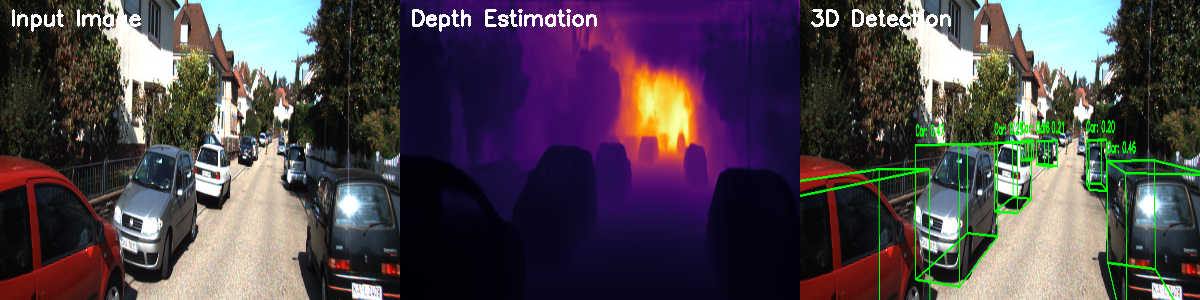

In [47]:
# 🚀 추론 스크립트 실행 (KITTI 샘플 이미지 테스트)
import subprocess
import os
from IPython.display import Image, display

# ⚠️ PyTorch 2.1.2와 호환되는 transformers 버전 설치 (4.36.2)
print("📦 transformers 라이브러리 설치 중 (PyTorch 2.1.2 호환 버전)...")
install_result = subprocess.run(
    ['/content/conda/envs/openmmlab/bin/pip', 'install', '-q', 'transformers==4.36.2'],
    capture_output=True,
    text=True
)
if install_result.returncode == 0:
    print("✅ transformers 4.36.2 설치 완료!")
else:
    print(f"⚠️ 설치 중 경고: {install_result.stderr}")

print("\n" + "="*70)
print("▶️ 단일 이미지 3D Object Detection 추론 실행 중...")
print("="*70)

env = os.environ.copy()
env['PYTHONPATH'] = '/content/mmdetection3d:' + env.get('PYTHONPATH', '')

proc = subprocess.Popen(
    ['/content/conda/envs/openmmlab/bin/python', '-u', 'inference_single_image.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    cwd='/content/mmdetection3d',
    env=env
)

for line in proc.stdout:
    print(line, end='')

proc.wait()

# 결과 이미지 표시
output_dir = '/content/mmdetection3d/inference_output'
summary_path = os.path.join(output_dir, 'inference_summary.png')

if os.path.exists(summary_path):
    print("\n\n" + "="*70)
    print("🖼️ 추론 결과 요약:")
    print("="*70)
    display(Image(summary_path))
else:
    # 개별 결과 파일 확인
    result_path = os.path.join(output_dir, 'detection_result.png')
    if os.path.exists(result_path):
        print("\n🖼️ Detection 결과:")
        display(Image(result_path))
    else:
        print("\n❌ 결과 이미지가 생성되지 않았습니다.")

# 외부 이미지

In [35]:
%%writefile /content/mmdetection3d/inference_external_image.py
"""
🚀 External Image 3D Object Detection with Distance (Auto Calibration)
"""

import os
import sys

import matplotlib
matplotlib.use('Agg')

import torch
import numpy as np
import cv2
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from mmengine.config import Config
from mmdet3d.utils import register_all_modules
from mmdet3d.structures import LiDARInstance3DBoxes
import warnings

warnings.filterwarnings('ignore')
register_all_modules()

# ==============================================================================
# ⚙️ Configuration
# ==============================================================================
class InferenceConfig:
    CHECKPOINT_PATH = '/content/mmdetection3d/work_dirs/epoch_20.pth'
    CONFIG_PATH = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'

    DEPTH_MODEL = "vinvino02/glpn-kitti"

    MIN_DEPTH = 2.0
    MAX_DEPTH = 60.0
    Z_MIN = -3.0
    Z_MAX = 1.0
    NUM_POINTS = 25000

    SCORE_THRESHOLD = 0.3

    CLASSES = None

    CLASS_COLORS = {
        'Car': (0, 255, 0),
        'Pedestrian': (255, 0, 0),
        'Cyclist': (0, 0, 255)
    }

# ==============================================================================
# 📏 Distance Calculator
# ==============================================================================
def calculate_distance(bbox_3d, mode='horizontal'):
    """
    3D Bounding Box로부터 거리 계산

    Args:
        bbox_3d: LiDARInstance3DBoxes (x, y, z, w, h, l, θ)
        mode: 'euclidean', 'horizontal', 'forward'

    Returns:
        distance (meters), (x, y, z) coordinates
    """
    # ✅ Box 중심 좌표 추출 (shape 확인)
    center = bbox_3d.gravity_center.cpu().numpy()  # shape: (1, 3) 또는 (3,)

    # ✅ 1D 배열로 변환
    if center.ndim == 2:
        center = center[0]  # (1, 3) -> (3,)

    x, y, z = center[0], center[1], center[2]

    if mode == 'euclidean':
        # 3D 유클리드 거리 (직선 거리)
        distance = np.sqrt(x**2 + y**2 + z**2)
    elif mode == 'horizontal':
        # 수평 거리 (높이 무시, 가장 실용적)
        distance = np.sqrt(x**2 + y**2)
    elif mode == 'forward':
        # 전방 거리 (X축 거리만)
        distance = x
    else:
        distance = np.sqrt(x**2 + y**2)

    return distance, (x, y, z)

# ==============================================================================
# 📐 Auto Calibration Generator
# ==============================================================================
def create_auto_calibration(image_shape, focal_length_ratio=1.0):
    """
    이미지 크기 기반 Calibration 자동 생성

    Args:
        image_shape: (height, width)
        focal_length_ratio: focal length 조정 비율 (0.8~1.2 권장)
    """
    h, w = image_shape

    fx = fy = w * focal_length_ratio
    cx = w / 2.0
    cy = h / 2.0

    print(f"\n{'='*70}")
    print(f"📐 이미지 기반 Auto Calibration 생성")
    print(f"{'='*70}")
    print(f"   이미지 크기: {w} × {h}")
    print(f"   Focal length: {fx:.1f} pixels (ratio: {focal_length_ratio})")
    print(f"   Principal point: ({cx:.1f}, {cy:.1f})")
    print(f"{'='*70}\n")

    P2 = np.array([
        [fx, 0.0, cx, 0.0],
        [0.0, fy, cy, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ], dtype=np.float32)

    R0 = np.eye(4, dtype=np.float32)

    Tr = np.eye(4, dtype=np.float32)
    Tr[:3, :4] = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
        [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01]
    ], dtype=np.float32)

    return {
        'P2': P2,
        'R0_rect': R0,
        'Tr_velo_to_cam': Tr
    }

# ==============================================================================
# 📷 GLPN Depth Estimation
# ==============================================================================
class DepthEstimator:
    def __init__(self, model_name=InferenceConfig.DEPTH_MODEL):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🔄 GLPN Depth 모델 로드 중... ({self.device})")

        self.processor = GLPNImageProcessor.from_pretrained(model_name)
        self.model = GLPNForDepthEstimation.from_pretrained(
            model_name, use_safetensors=True
        ).to(self.device)
        self.model.eval()

        print("✅ GLPN Depth 모델 로드 완료!")

    def estimate_depth(self, image: Image.Image) -> np.ndarray:
        w, h = image.size
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            pred_depth = self.model(**inputs).predicted_depth

        pred_depth = torch.nn.functional.interpolate(
            pred_depth.unsqueeze(1),
            size=(h, w),
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()

        return pred_depth

# ==============================================================================
# ☁️ Pseudo-LiDAR Generator
# ==============================================================================
class PseudoLidarGenerator:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def generate(self, depth_map: np.ndarray, calib_data: dict) -> np.ndarray:
        h, w = depth_map.shape

        P2 = calib_data['P2']
        R0_rect = calib_data['R0_rect']
        Tr_velo_to_cam = calib_data['Tr_velo_to_cam']

        K = P2[:3, :3]
        fx, fy = K[0, 0], K[1, 1]
        cx, cy = K[0, 2], K[1, 2]

        u, v = np.meshgrid(np.arange(w), np.arange(h))

        mask = (depth_map > self.config.MIN_DEPTH) & (depth_map < self.config.MAX_DEPTH)
        z = depth_map[mask]
        u_valid = u[mask]
        v_valid = v[mask]

        if len(z) == 0:
            print("⚠️ 유효한 depth 값이 없습니다!")
            return np.zeros((0, 4), dtype=np.float32)

        x_cam = (u_valid - cx) * z / fx
        y_cam = (v_valid - cy) * z / fy
        points_cam = np.stack([x_cam, y_cam, z], axis=-1)

        R0_inv = np.linalg.inv(R0_rect[:3, :3])
        Tr_4x4 = np.eye(4)
        Tr_4x4[:3, :4] = Tr_velo_to_cam[:3, :4]
        Tr_inv = np.linalg.inv(Tr_4x4)

        points_ref = (R0_inv @ points_cam.T).T
        points_ref_h = np.hstack([points_ref, np.ones((len(points_ref), 1))])
        points_velo = (Tr_inv @ points_ref_h.T).T[:, :3]

        z_vals = points_velo[:, 2]
        z_mask = (z_vals > self.config.Z_MIN) & (z_vals < self.config.Z_MAX)
        points_velo = points_velo[z_mask]

        num_points = points_velo.shape[0]
        if num_points > self.config.NUM_POINTS:
            choice_idx = np.random.choice(num_points, self.config.NUM_POINTS, replace=False)
            points_velo = points_velo[choice_idx]

        intensity = np.zeros((points_velo.shape[0], 1), dtype=np.float32)
        points = np.hstack([points_velo, intensity]).astype(np.float32)

        print(f"☁️ Pseudo-LiDAR 생성 완료: {points.shape[0]:,} points")

        return points

# ==============================================================================
# 🤖 MVXNet Inference
# ==============================================================================
class MVXNetInference:
    def __init__(self, config=InferenceConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.cfg = None
        self.classes = None

    def load_model(self):
        print(f"🔄 MVXNet Student 모델 로드 중...")

        self.cfg = Config.fromfile(self.config.CONFIG_PATH)

        if hasattr(self.cfg, 'class_names'):
            self.classes = self.cfg.class_names
        elif hasattr(self.cfg, 'train_dataloader'):
            dataset_cfg = self.cfg.train_dataloader.dataset
            if hasattr(dataset_cfg, 'dataset') and hasattr(dataset_cfg.dataset, 'metainfo'):
                self.classes = dataset_cfg.dataset.metainfo.get('classes', None)

        if self.classes is None:
            self.classes = ['Car', 'Pedestrian', 'Cyclist']

        print(f"✅ 탐지 가능 클래스: {self.classes}")
        self.config.CLASSES = self.classes

        checkpoint = torch.load(self.config.CHECKPOINT_PATH, map_location='cpu')

        if 'student_state_dict' in checkpoint:
            student_weights = checkpoint['student_state_dict']
            cleaned_weights = {}
            for key, value in student_weights.items():
                if key.startswith('_orig_mod.'):
                    new_key = key.replace('_orig_mod.', '')
                    cleaned_weights[new_key] = value
                else:
                    cleaned_weights[key] = value
            state_dict = cleaned_weights
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
        else:
            state_dict = checkpoint

        from mmdet3d.registry import MODELS
        self.model = MODELS.build(self.cfg.model).to(self.device)
        self.model.load_state_dict(state_dict, strict=False)
        self.model.eval()

        print(f"✅ 모델 로드 완료! (Device: {self.device})")

    def inference(self, image: np.ndarray, points: np.ndarray, calib: dict) -> dict:
        if self.model is None:
            self.load_model()

        from mmdet3d.structures import LiDARInstance3DBoxes
        from mmengine.structures import InstanceData
        from mmdet3d.structures import Det3DDataSample

        img = image.copy()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)

        mean = np.array([103.530, 116.280, 123.675], dtype=np.float32)
        std = np.array([57.375, 57.120, 58.395], dtype=np.float32)
        img = (img - mean) / std
        img = img.transpose(2, 0, 1)
        img_tensor = torch.from_numpy(img).float().unsqueeze(0).to(self.device)

        img_shape = image.shape[:2]
        points_tensor = torch.from_numpy(points).float().to(self.device)

        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        metainfo = {
            'sample_idx': 0,
            'img_path': '',
            'lidar_path': '',
            'img_shape': img_shape,
            'ori_shape': img_shape,
            'pad_shape': img_shape,
            'scale_factor': np.array([1.0, 1.0], dtype=np.float32),
            'flip': False,
            'flip_direction': None,
            'box_type_3d': LiDARInstance3DBoxes,
            'box_mode_3d': 'lidar',
            'lidar2img': lidar2img,
            'cam2img': calib['P2'][:3, :3],
        }

        data_sample = Det3DDataSample()
        data_sample.set_metainfo(metainfo)

        gt_instances_3d = InstanceData()
        gt_instances_3d.bboxes_3d = LiDARInstance3DBoxes(torch.zeros((0, 7)))
        gt_instances_3d.labels_3d = torch.zeros(0, dtype=torch.long)
        data_sample.gt_instances_3d = gt_instances_3d

        with torch.no_grad():
            voxel_dict = self.model.data_preprocessor.voxelize(
                [points_tensor],
                [data_sample]
            )

        print(f"   Voxel 수: {voxel_dict['voxels'].shape[0]:,}")

        with torch.no_grad():
            batch_inputs_dict = {
                'points': [points_tensor],
                'voxels': voxel_dict,
                'imgs': img_tensor
            }

            batch_data_samples = [data_sample]
            results = self.model.forward(
                batch_inputs_dict,
                batch_data_samples,
                mode='predict'
            )

        return results[0]

# ==============================================================================
# 🎨 Visualization with Distance
# ==============================================================================
class Visualizer:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def draw_3d_boxes_with_distance(self, image: np.ndarray, result, calib: dict) -> np.ndarray:
        """✅ 3D Box + 거리 표시"""
        img = image.copy()

        pred_instances = result.pred_instances_3d
        bboxes_3d = pred_instances.bboxes_3d
        scores = pred_instances.scores_3d.cpu().numpy()
        labels = pred_instances.labels_3d.cpu().numpy()

        mask = scores > self.config.SCORE_THRESHOLD

        if mask.sum() == 0:
            print(f"⚠️ Threshold {self.config.SCORE_THRESHOLD} 이상의 detection이 없습니다.")
            if len(scores) > 0:
                print(f"   최대 score: {scores.max():.4f}")
            return img

        bboxes = bboxes_3d[mask]
        scores = scores[mask]
        labels = labels[mask]

        print(f"\n🔍 Detection 결과 (거리 측정 포함):")
        print(f"{'='*70}")
        print(f"{'No':<4} {'Class':<12} {'Score':<8} {'거리(m)':<10} {'좌표(x,y,z)'}")
        print(f"{'='*70}")

        corners = bboxes.corners.cpu().numpy()
        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        for i in range(len(bboxes)):
            bbox = bboxes[i:i+1]  # Single box
            score = scores[i]
            label = labels[i]
            corner = corners[i]

            class_name = self.config.CLASSES[label] if label < len(self.config.CLASSES) else f'Unknown({label})'
            color = self.config.CLASS_COLORS.get(class_name, (255, 255, 0))

            # ✅ 거리 계산
            distance, (x, y, z) = calculate_distance(bbox, mode='horizontal')

            # 콘솔 출력
            print(f"{i+1:<4} {class_name:<12} {score:<8.3f} {distance:<10.2f} ({x:.2f}, {y:.2f}, {z:.2f})")

            # 2D 투영
            corner_homo = np.hstack([corner, np.ones((8, 1))])
            corner_2d_homo = (lidar2img @ corner_homo.T).T
            corner_2d = corner_2d_homo[:, :2] / corner_2d_homo[:, 2:3]

            valid = corner_2d_homo[:, 2] > 0
            if not valid.all():
                continue

            corner_2d = corner_2d.astype(int)

            # 3D Box 그리기
            edges = [
                (0, 1), (1, 2), (2, 3), (3, 0),
                (4, 5), (5, 6), (6, 7), (7, 4),
                (0, 4), (1, 5), (2, 6), (3, 7)
            ]

            for e in edges:
                pt1 = tuple(corner_2d[e[0]])
                pt2 = tuple(corner_2d[e[1]])
                cv2.line(img, pt1, pt2, color, 2)

            # ✅ 텍스트: 클래스 + 점수 + 거리
            text = f"{class_name}: {score:.2f} | {distance:.1f}m"
            text_pos = (corner_2d[:, 0].min(), corner_2d[:, 1].min() - 10)

            # 텍스트 배경 (가독성 향상)
            (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
            cv2.rectangle(img,
                         (text_pos[0], text_pos[1] - text_h - 5),
                         (text_pos[0] + text_w, text_pos[1] + 5),
                         (0, 0, 0), -1)

            # 텍스트 그리기
            cv2.putText(img, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        print(f"{'='*70}\n")

        return img

    def visualize_depth(self, depth_map: np.ndarray, save_path: str = None):
        depth_normalized = depth_map.copy()
        depth_normalized = (depth_normalized - depth_normalized.min()) / (depth_normalized.max() - depth_normalized.min() + 1e-8)
        depth_normalized = (depth_normalized * 255).astype(np.uint8)
        depth_colored = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_INFERNO)

        if save_path:
            cv2.imwrite(save_path, depth_colored)

        return depth_colored

    def create_summary(self, image_np, depth_map, result_img, save_path):
        h, w = 300, 400

        img1 = cv2.resize(image_np, (w, h))
        if len(img1.shape) == 3 and img1.shape[2] == 3:
            img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)

        depth_vis = self.visualize_depth(depth_map)
        img2 = cv2.resize(depth_vis, (w, h))
        img3 = cv2.resize(result_img, (w, h))

        summary = np.hstack([img1, img2, img3])

        cv2.putText(summary, "Input", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(summary, "Depth", (w + 10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
        cv2.putText(summary, "Detection+Distance", (2*w + 10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255, 255, 255), 2)

        cv2.imwrite(save_path, summary)
        print(f"💾 결과 저장: {save_path}")

        return summary

# ==============================================================================
# 🎯 Main Pipeline
# ==============================================================================
def run_inference(image_path: str, output_dir: str = './inference_output', focal_ratio=1.0):
    """
    Args:
        image_path: 입력 이미지 경로
        output_dir: 출력 디렉토리
        focal_ratio: Focal length 비율 조정 (0.8~1.2 권장)
                    - 1.0보다 크면: 박스가 더 작아짐 (더 멀리)
                    - 1.0보다 작으면: 박스가 더 커짐 (더 가까이)
    """
    os.makedirs(output_dir, exist_ok=True)

    print("="*70)
    print("🚀 3D Object Detection with Distance Measurement")
    print("="*70)

    print(f"\n📷 입력: {image_path}")
    image_pil = Image.open(image_path).convert('RGB')
    image_np = np.array(image_pil)
    image_bgr = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)
    print(f"   크기: {image_np.shape}")

    # ✅ Auto Calibration 생성
    calib = create_auto_calibration(image_np.shape[:2], focal_ratio)

    print("="*70)
    print("🔮 Depth Estimation")
    print("="*70)
    depth_estimator = DepthEstimator()
    depth_map = depth_estimator.estimate_depth(image_pil)

    DEPTH_SCALE = 10.0
    depth_map = depth_map * DEPTH_SCALE
    print(f"   Depth 범위: {depth_map.min():.2f}m ~ {depth_map.max():.2f}m")

    print("\n" + "="*70)
    print("☁️ Pseudo-LiDAR Generation")
    print("="*70)
    lidar_generator = PseudoLidarGenerator()
    points = lidar_generator.generate(depth_map, calib)

    if points.shape[0] == 0:
        print("❌ Pseudo-LiDAR 생성 실패!")
        return

    print("\n" + "="*70)
    print("🤖 3D Object Detection")
    print("="*70)
    mvxnet = MVXNetInference()
    result = mvxnet.inference(image_bgr, points, calib)

    print("\n" + "="*70)
    print("🎨 Visualization")
    print("="*70)
    visualizer = Visualizer()

    # ✅ 거리 포함하여 시각화
    result_img = visualizer.draw_3d_boxes_with_distance(image_bgr, result, calib)

    summary_path = os.path.join(output_dir, 'result.png')
    visualizer.create_summary(image_np, depth_map, result_img, summary_path)

    print("\n✅ 완료!")
    print(f"📂 결과: {os.path.abspath(summary_path)}")

    return result

# ==============================================================================
# 🎬 Entry Point
# ==============================================================================
if __name__ == '__main__':
    import sys

    if len(sys.argv) > 1:
        IMAGE_PATH = sys.argv[1]
        OUTPUT_DIR = sys.argv[2] if len(sys.argv) > 2 else '/content/output'
        FOCAL_RATIO = float(sys.argv[3]) if len(sys.argv) > 3 else 1.0
    else:
        IMAGE_PATH = '/content/nano_test1.jpg'
        OUTPUT_DIR = '/content/output'
        FOCAL_RATIO = 1.0

    if os.path.exists(IMAGE_PATH):
        run_inference(IMAGE_PATH, OUTPUT_DIR, FOCAL_RATIO)
    else:
        print(f"❌ 이미지를 찾을 수 없습니다: {IMAGE_PATH}")


Overwriting /content/mmdetection3d/inference_external_image.py


In [13]:
from google.colab import files
uploaded = files.upload()
# 이미지 파일 선택해서 업로드


Saving nano_test1.png to nano_test1.png


In [36]:
!cd /content/mmdetection3d && \
 export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH && \
 export NUMBA_DISABLE_CUDA=1 && \
 /content/conda/envs/openmmlab/bin/python inference_external_image.py /content/nano_test1.png


🚀 3D Object Detection with Distance Measurement

📷 입력: /content/nano_test1.png
   크기: (559, 1024, 3)

📐 이미지 기반 Auto Calibration 생성
   이미지 크기: 1024 × 559
   Focal length: 1024.0 pixels (ratio: 1.0)
   Principal point: (512.0, 279.5)

🔮 Depth Estimation
🔄 GLPN Depth 모델 로드 중... (cuda)
✅ GLPN Depth 모델 로드 완료!
   Depth 범위: 3.68m ~ 96.01m

☁️ Pseudo-LiDAR Generation
☁️ Pseudo-LiDAR 생성 완료: 25,000 points

🤖 3D Object Detection
🔄 MVXNet Student 모델 로드 중...
✅ 탐지 가능 클래스: ['Pedestrian', 'Cyclist', 'Car']
✅ 모델 로드 완료! (Device: cuda)
   Voxel 수: 25,000

🎨 Visualization

🔍 Detection 결과 (거리 측정 포함):
No   Class        Score    거리(m)      좌표(x,y,z)
1    Car          0.637    6.39       (6.23, -1.41, -1.09)
2    Car          0.457    17.03      (16.05, 5.70, -1.15)
3    Car          0.391    16.54      (16.48, -1.40, -0.90)
4    Car          0.383    26.87      (26.80, 1.84, -0.73)

💾 결과 저장: /content/output/result.png

✅ 완료!
📂 결과: /content/output/result.png


# 실시간 탐지(실제 동영상)

In [38]:
%%writefile /content/mmdetection3d/inference_video.py
"""
🎬 Video 3D Object Detection with Distance (실시간/준실시간)
"""

import os
import sys
import time
from collections import deque

import matplotlib
matplotlib.use('Agg')

import torch
import numpy as np
import cv2
from PIL import Image
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
from mmengine.config import Config
from mmdet3d.utils import register_all_modules
from mmdet3d.structures import LiDARInstance3DBoxes
import warnings

warnings.filterwarnings('ignore')
register_all_modules()

# ==============================================================================
# ⚙️ Configuration
# ==============================================================================
class InferenceConfig:
    CHECKPOINT_PATH = '/content/mmdetection3d/work_dirs/epoch_20.pth'
    CONFIG_PATH = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'

    DEPTH_MODEL = "vinvino02/glpn-kitti"

    MIN_DEPTH = 2.0
    MAX_DEPTH = 60.0
    Z_MIN = -3.0
    Z_MAX = 1.0
    NUM_POINTS = 25000

    SCORE_THRESHOLD = 0.3

    CLASSES = None

    CLASS_COLORS = {
        'Car': (0, 255, 0),
        'Pedestrian': (255, 0, 0),
        'Cyclist': (0, 0, 255)
    }

    # ✅ 비디오 설정
    SKIP_FRAMES = 1  # 1: 모든 프레임, 2: 2프레임마다 1개, 3: 3프레임마다 1개
    RESIZE_WIDTH = 640  # None이면 원본 크기, 작을수록 빠름
    SHOW_FPS = True

# ==============================================================================
# 📏 Distance Calculator
# ==============================================================================
def calculate_distance(bbox_3d, mode='horizontal'):
    center = bbox_3d.gravity_center.cpu().numpy()
    if center.ndim == 2:
        center = center[0]
    x, y, z = float(center[0]), float(center[1]), float(center[2])

    if mode == 'horizontal':
        distance = np.sqrt(x**2 + y**2)
    else:
        distance = np.sqrt(x**2 + y**2)

    return float(distance), (x, y, z)

def create_auto_calibration(image_shape, focal_length_ratio=1.0):
    h, w = image_shape
    fx = fy = w * focal_length_ratio
    cx, cy = w / 2.0, h / 2.0

    P2 = np.array([
        [fx, 0.0, cx, 0.0],
        [0.0, fy, cy, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ], dtype=np.float32)

    R0 = np.eye(4, dtype=np.float32)
    Tr = np.eye(4, dtype=np.float32)
    Tr[:3, :4] = np.array([
        [7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
        [1.480249e-02, 7.280733e-04, -9.998902e-01, -7.631618e-02],
        [9.998621e-01, 7.523790e-03, 1.480755e-02, -2.717806e-01]
    ], dtype=np.float32)

    return {'P2': P2, 'R0_rect': R0, 'Tr_velo_to_cam': Tr}

# ==============================================================================
# 📷 GLPN Depth Estimation
# ==============================================================================
class DepthEstimator:
    def __init__(self, model_name=InferenceConfig.DEPTH_MODEL):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🔄 GLPN Depth 모델 로드 중... ({self.device})")

        self.processor = GLPNImageProcessor.from_pretrained(model_name)
        self.model = GLPNForDepthEstimation.from_pretrained(
            model_name, use_safetensors=True
        ).to(self.device)
        self.model.eval()

        print("✅ GLPN Depth 모델 로드 완료!")

    def estimate_depth(self, image: Image.Image) -> np.ndarray:
        w, h = image.size
        inputs = self.processor(images=image, return_tensors="pt").to(self.device)

        with torch.no_grad():
            pred_depth = self.model(**inputs).predicted_depth

        pred_depth = torch.nn.functional.interpolate(
            pred_depth.unsqueeze(1),
            size=(h, w),
            mode="bicubic",
            align_corners=False
        ).squeeze().cpu().numpy()

        return pred_depth

# ==============================================================================
# ☁️ Pseudo-LiDAR Generator
# ==============================================================================
class PseudoLidarGenerator:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def generate(self, depth_map: np.ndarray, calib_data: dict) -> np.ndarray:
        h, w = depth_map.shape
        P2 = calib_data['P2']
        R0_rect = calib_data['R0_rect']
        Tr_velo_to_cam = calib_data['Tr_velo_to_cam']

        K = P2[:3, :3]
        fx, fy = K[0, 0], K[1, 1]
        cx, cy = K[0, 2], K[1, 2]

        u, v = np.meshgrid(np.arange(w), np.arange(h))
        mask = (depth_map > self.config.MIN_DEPTH) & (depth_map < self.config.MAX_DEPTH)
        z = depth_map[mask]
        u_valid, v_valid = u[mask], v[mask]

        if len(z) == 0:
            return np.zeros((0, 4), dtype=np.float32)

        x_cam = (u_valid - cx) * z / fx
        y_cam = (v_valid - cy) * z / fy
        points_cam = np.stack([x_cam, y_cam, z], axis=-1)

        R0_inv = np.linalg.inv(R0_rect[:3, :3])
        Tr_4x4 = np.eye(4)
        Tr_4x4[:3, :4] = Tr_velo_to_cam[:3, :4]
        Tr_inv = np.linalg.inv(Tr_4x4)

        points_ref = (R0_inv @ points_cam.T).T
        points_ref_h = np.hstack([points_ref, np.ones((len(points_ref), 1))])
        points_velo = (Tr_inv @ points_ref_h.T).T[:, :3]

        z_vals = points_velo[:, 2]
        z_mask = (z_vals > self.config.Z_MIN) & (z_vals < self.config.Z_MAX)
        points_velo = points_velo[z_mask]

        num_points = points_velo.shape[0]
        if num_points > self.config.NUM_POINTS:
            choice_idx = np.random.choice(num_points, self.config.NUM_POINTS, replace=False)
            points_velo = points_velo[choice_idx]

        intensity = np.zeros((points_velo.shape[0], 1), dtype=np.float32)
        return np.hstack([points_velo, intensity]).astype(np.float32)

# ==============================================================================
# 🤖 MVXNet Inference
# ==============================================================================
class MVXNetInference:
    def __init__(self, config=InferenceConfig):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.cfg = None
        self.classes = None

    def load_model(self):
        print(f"🔄 MVXNet Student 모델 로드 중...")

        self.cfg = Config.fromfile(self.config.CONFIG_PATH)

        if hasattr(self.cfg, 'class_names'):
            self.classes = self.cfg.class_names
        else:
            self.classes = ['Car', 'Pedestrian', 'Cyclist']

        self.config.CLASSES = self.classes
        checkpoint = torch.load(self.config.CHECKPOINT_PATH, map_location='cpu')

        if 'student_state_dict' in checkpoint:
            state_dict = {k.replace('_orig_mod.', ''): v for k, v in checkpoint['student_state_dict'].items()}
        else:
            state_dict = checkpoint.get('state_dict', checkpoint)

        from mmdet3d.registry import MODELS
        self.model = MODELS.build(self.cfg.model).to(self.device)
        self.model.load_state_dict(state_dict, strict=False)
        self.model.eval()

        print(f"✅ 모델 로드 완료! (Device: {self.device})")

    def inference(self, image: np.ndarray, points: np.ndarray, calib: dict):
        if self.model is None:
            self.load_model()

        from mmdet3d.structures import LiDARInstance3DBoxes
        from mmengine.structures import InstanceData
        from mmdet3d.structures import Det3DDataSample

        img = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB).astype(np.float32)
        mean = np.array([103.530, 116.280, 123.675], dtype=np.float32)
        std = np.array([57.375, 57.120, 58.395], dtype=np.float32)
        img = (img - mean) / std
        img_tensor = torch.from_numpy(img.transpose(2, 0, 1)).float().unsqueeze(0).to(self.device)

        points_tensor = torch.from_numpy(points).float().to(self.device)
        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        metainfo = {
            'sample_idx': 0, 'img_path': '', 'lidar_path': '',
            'img_shape': image.shape[:2], 'ori_shape': image.shape[:2], 'pad_shape': image.shape[:2],
            'scale_factor': np.array([1.0, 1.0], dtype=np.float32),
            'flip': False, 'flip_direction': None,
            'box_type_3d': LiDARInstance3DBoxes, 'box_mode_3d': 'lidar',
            'lidar2img': lidar2img, 'cam2img': calib['P2'][:3, :3],
        }

        data_sample = Det3DDataSample()
        data_sample.set_metainfo(metainfo)
        gt_instances_3d = InstanceData()
        gt_instances_3d.bboxes_3d = LiDARInstance3DBoxes(torch.zeros((0, 7)))
        gt_instances_3d.labels_3d = torch.zeros(0, dtype=torch.long)
        data_sample.gt_instances_3d = gt_instances_3d

        with torch.no_grad():
            voxel_dict = self.model.data_preprocessor.voxelize([points_tensor], [data_sample])
            results = self.model.forward(
                {'points': [points_tensor], 'voxels': voxel_dict, 'imgs': img_tensor},
                [data_sample],
                mode='predict'
            )

        return results[0]

# ==============================================================================
# 🎨 Visualizer
# ==============================================================================
class VideoVisualizer:
    def __init__(self, config=InferenceConfig):
        self.config = config

    def draw_3d_boxes_with_distance(self, image: np.ndarray, result, calib: dict) -> np.ndarray:
        img = image.copy()

        pred_instances = result.pred_instances_3d
        bboxes_3d = pred_instances.bboxes_3d
        scores = pred_instances.scores_3d.cpu().numpy()
        labels = pred_instances.labels_3d.cpu().numpy()

        mask = scores > self.config.SCORE_THRESHOLD
        if mask.sum() == 0:
            return img

        bboxes = bboxes_3d[mask]
        scores = scores[mask]
        labels = labels[mask]

        corners = bboxes.corners.cpu().numpy()
        lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

        for i in range(len(bboxes)):
            bbox = bboxes[i:i+1]
            score = scores[i]
            label = labels[i]
            corner = corners[i]

            class_name = self.config.CLASSES[label] if label < len(self.config.CLASSES) else 'Unknown'
            color = self.config.CLASS_COLORS.get(class_name, (255, 255, 0))

            distance, _ = calculate_distance(bbox, mode='horizontal')

            corner_homo = np.hstack([corner, np.ones((8, 1))])
            corner_2d_homo = (lidar2img @ corner_homo.T).T
            corner_2d = corner_2d_homo[:, :2] / corner_2d_homo[:, 2:3]

            valid = corner_2d_homo[:, 2] > 0
            if not valid.all():
                continue

            corner_2d = corner_2d.astype(int)

            edges = [
                (0, 1), (1, 2), (2, 3), (3, 0),
                (4, 5), (5, 6), (6, 7), (7, 4),
                (0, 4), (1, 5), (2, 6), (3, 7)
            ]

            for e in edges:
                pt1 = tuple(corner_2d[e[0]])
                pt2 = tuple(corner_2d[e[1]])
                cv2.line(img, pt1, pt2, color, 2)

            text = f"{class_name}: {score:.2f} | {distance:.1f}m"
            text_pos = (corner_2d[:, 0].min(), corner_2d[:, 1].min() - 10)

            (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
            cv2.rectangle(img,
                         (text_pos[0], text_pos[1] - text_h - 5),
                         (text_pos[0] + text_w, text_pos[1] + 5),
                         (0, 0, 0), -1)

            cv2.putText(img, text, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        return img

# ==============================================================================
# 🎬 Video Processor
# ==============================================================================
class VideoProcessor:
    def __init__(self, config=InferenceConfig):
        self.config = config
        self.depth_estimator = None
        self.lidar_generator = None
        self.mvxnet = None
        self.visualizer = None

        # ✅ FPS 계산용
        self.fps_queue = deque(maxlen=30)

    def initialize(self):
        """모델 한 번만 로드 (속도 최적화)"""
        print("🔄 모델 초기화 중...")
        self.depth_estimator = DepthEstimator()
        self.lidar_generator = PseudoLidarGenerator(self.config)
        self.mvxnet = MVXNetInference(self.config)
        self.mvxnet.load_model()  # 미리 로드
        self.visualizer = VideoVisualizer(self.config)
        print("✅ 초기화 완료!\n")

    def process_frame(self, frame_bgr, calib, frame_idx):
        """단일 프레임 처리"""
        start_time = time.time()

        # 1. Resize (속도 향상)
        if self.config.RESIZE_WIDTH:
            h, w = frame_bgr.shape[:2]
            ratio = self.config.RESIZE_WIDTH / w
            new_h = int(h * ratio)
            frame_resized = cv2.resize(frame_bgr, (self.config.RESIZE_WIDTH, new_h))
        else:
            frame_resized = frame_bgr

        # 2. Depth Estimation
        frame_rgb = cv2.cvtColor(frame_resized, cv2.COLOR_BGR2RGB)
        image_pil = Image.fromarray(frame_rgb)
        depth_map = self.depth_estimator.estimate_depth(image_pil) * 10.0

        # 3. Pseudo-LiDAR
        points = self.lidar_generator.generate(depth_map, calib)

        if points.shape[0] == 0:
            return frame_resized

        # 4. 3D Detection
        result = self.mvxnet.inference(frame_resized, points, calib)

        # 5. Visualization
        result_img = self.visualizer.draw_3d_boxes_with_distance(frame_resized, result, calib)

        # FPS 계산
        elapsed = time.time() - start_time
        self.fps_queue.append(1.0 / elapsed)
        avg_fps = np.mean(self.fps_queue)

        # FPS 표시
        if self.config.SHOW_FPS:
            cv2.putText(result_img, f"FPS: {avg_fps:.1f} | Frame: {frame_idx}",
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

        return result_img

    def process_video(self, video_path, output_path, focal_ratio=1.0):
        """비디오 처리"""
        if not self.mvxnet:
            self.initialize()

        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"❌ 비디오를 열 수 없습니다: {video_path}")
            return

        # 비디오 정보
        fps = cap.get(cv2.CAP_PROP_FPS)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        if self.config.RESIZE_WIDTH:
            ratio = self.config.RESIZE_WIDTH / w
            out_w = self.config.RESIZE_WIDTH
            out_h = int(h * ratio)
        else:
            out_w, out_h = w, h

        print(f"📹 비디오 정보:")
        print(f"   원본 크기: {w} × {h}")
        print(f"   처리 크기: {out_w} × {out_h}")
        print(f"   FPS: {fps:.2f}")
        print(f"   총 프레임: {total_frames}")
        print(f"   프레임 스킵: {self.config.SKIP_FRAMES}")
        print()

        # Calibration (첫 프레임 기준)
        calib = create_auto_calibration((out_h, out_w), focal_ratio)

        # VideoWriter
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps / self.config.SKIP_FRAMES, (out_w, out_h))

        frame_idx = 0
        processed_frames = 0

        print("🎬 처리 시작...")

        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # 프레임 스킵
            if frame_idx % self.config.SKIP_FRAMES != 0:
                frame_idx += 1
                continue

            # 처리
            result_frame = self.process_frame(frame, calib, frame_idx)
            out.write(result_frame)

            processed_frames += 1
            if processed_frames % 10 == 0:
                print(f"   처리 중: {processed_frames}/{total_frames // self.config.SKIP_FRAMES} 프레임")

            frame_idx += 1

        cap.release()
        out.release()

        print(f"\n✅ 완료!")
        print(f"📂 출력: {os.path.abspath(output_path)}")
        print(f"   총 {processed_frames}개 프레임 처리")

# ==============================================================================
# 🎯 Main
# ==============================================================================
def main():
    import sys

    if len(sys.argv) < 2:
        print("사용법: python inference_video.py <video_path> [output_path] [focal_ratio]")
        return

    video_path = sys.argv[1]
    output_path = sys.argv[2] if len(sys.argv) > 2 else '/content/output_video.mp4'
    focal_ratio = float(sys.argv[3]) if len(sys.argv) > 3 else 1.0

    if not os.path.exists(video_path):
        print(f"❌ 비디오를 찾을 수 없습니다: {video_path}")
        return

    processor = VideoProcessor()
    processor.process_video(video_path, output_path, focal_ratio)

if __name__ == '__main__':
    main()


Overwriting /content/mmdetection3d/inference_video.py


In [39]:
# 기본 설정
!cd /content/mmdetection3d && \
 export PYTHONPATH=/content/mmdetection3d:$PYTHONPATH && \
 export NUMBA_DISABLE_CUDA=1 && \
 /content/conda/envs/openmmlab/bin/python inference_video.py \
   /content/test_video.mp4 \
   /content/output_video.mp4

# 속도 향상 (2프레임마다 1개 처리)
# inference_video.py 내 SKIP_FRAMES = 2 로 수정

# 더 빠르게 (해상도 낮춤)
# RESIZE_WIDTH = 480 로 수정


🔄 모델 초기화 중...
🔄 GLPN Depth 모델 로드 중... (cuda)
✅ GLPN Depth 모델 로드 완료!
🔄 MVXNet Student 모델 로드 중...
✅ 모델 로드 완료! (Device: cuda)
✅ 초기화 완료!

📹 비디오 정보:
   원본 크기: 1280 × 720
   처리 크기: 640 × 360
   FPS: 24.00
   총 프레임: 216
   프레임 스킵: 1

🎬 처리 시작...
   처리 중: 10/216 프레임
   처리 중: 20/216 프레임
   처리 중: 30/216 프레임
   처리 중: 40/216 프레임
   처리 중: 50/216 프레임
   처리 중: 60/216 프레임
   처리 중: 70/216 프레임
   처리 중: 80/216 프레임
   처리 중: 90/216 프레임
   처리 중: 100/216 프레임
   처리 중: 110/216 프레임
   처리 중: 120/216 프레임
   처리 중: 130/216 프레임
   처리 중: 140/216 프레임
   처리 중: 150/216 프레임
   처리 중: 160/216 프레임
   처리 중: 170/216 프레임
   처리 중: 180/216 프레임
   처리 중: 190/216 프레임
   처리 중: 200/216 프레임
   처리 중: 210/216 프레임

✅ 완료!
📂 출력: /content/output_video.mp4
   총 216개 프레임 처리


# 평가

In [56]:
%%writefile /content/mmdetection3d/visualize_real_vs_pseudo.py
"""
🎨 Real LiDAR vs Pseudo-LiDAR 비교 (동일 모델 사용)
- 같은 Student 모델에 Real LiDAR vs Pseudo-LiDAR를 입력했을 때 차이 비교
- 🟢 녹색: Real LiDAR 입력 시 Detection
- 🔴 빨간색: Pseudo-LiDAR 입력 시 Detection
"""

import os
import sys
import torch
import numpy as np
import cv2
import warnings

warnings.filterwarnings('ignore')

from mmengine.config import Config
from mmdet3d.registry import MODELS
from mmdet3d.utils import register_all_modules
from mmdet3d.structures import LiDARInstance3DBoxes
from mmengine.structures import InstanceData
from mmdet3d.structures import Det3DDataSample

register_all_modules()

# ==============================================================================
# ⚙️ Configuration
# ==============================================================================
class VisConfig:
    DATA_ROOT = '/content/data/kitti/training'
    REAL_LIDAR_DIR = 'velodyne'
    PSEUDO_LIDAR_DIR = 'pseudo_velodyne'
    IMAGE_DIR = 'image_2'
    CALIB_DIR = 'calib'
    LABEL_DIR = 'label_2'

    CONFIG_PATH = 'configs/mvxnet/mvxnet_fpn_dv_second_secfpn_8xb2-80e_kitti-3d-3class.py'
    # 동일한 Student 모델 사용
    MODEL_CKPT = 'work_dirs/mvxnet_student_best.pth'

    OUTPUT_DIR = '/content/mmdetection3d/comparison_output_v2'

    NUM_SAMPLES = 5
    SCORE_THRESHOLD = 0.3

    CLASSES = ['Car', 'Pedestrian', 'Cyclist']

    REAL_COLOR = (0, 255, 0)    # 녹색 - Real LiDAR
    PSEUDO_COLOR = (0, 0, 255)  # 빨간색 - Pseudo-LiDAR

# ==============================================================================
# Helper Functions
# ==============================================================================
def load_calib(calib_path):
    data = {}
    with open(calib_path, 'r') as f:
        for line in f:
            if ':' not in line:
                continue
            key, val = line.split(':', 1)
            data[key.strip()] = np.array([float(x) for x in val.split()])

    P2 = data['P2'].reshape(3, 4)
    R0 = np.eye(4)
    R0[:3, :3] = data['R0_rect'].reshape(3, 3)
    Tr = np.eye(4)
    Tr[:3, :4] = data['Tr_velo_to_cam'].reshape(3, 4)

    return {'P2': P2, 'R0_rect': R0, 'Tr_velo_to_cam': Tr}

def load_points(bin_path):
    return np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

def load_gt_labels(label_path, classes):
    """KITTI Ground Truth 라벨 로드"""
    gt_boxes = []
    gt_labels = []

    if not os.path.exists(label_path):
        return gt_boxes, gt_labels

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 15:
                continue

            cls_name = parts[0]
            if cls_name not in classes:
                continue

            # KITTI format: h, w, l, x, y, z, ry (camera coords)
            h, w, l = float(parts[8]), float(parts[9]), float(parts[10])
            x, y, z = float(parts[11]), float(parts[12]), float(parts[13])
            ry = float(parts[14])

            gt_boxes.append([x, y - h/2, z, l, w, h, ry])  # camera to lidar approx
            gt_labels.append(classes.index(cls_name))

    return gt_boxes, gt_labels

def fix_checkpoint(checkpoint_state_dict, model):
    fixed = {}
    model_state = model.state_dict()

    for key, value in checkpoint_state_dict.items():
        if key in model_state:
            target = model_state[key].shape
            if 'weight' in key and value.ndim == 5 and value.shape != target:
                value = value.permute(1, 2, 3, 4, 0).contiguous()
        fixed[key] = value

    return fixed

def project_3d_to_2d(corners_3d, calib):
    lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']
    corners_homo = np.hstack([corners_3d, np.ones((8, 1))])
    corners_2d_homo = (lidar2img @ corners_homo.T).T

    valid = corners_2d_homo[:, 2] > 0
    if not valid.all():
        return None

    corners_2d = corners_2d_homo[:, :2] / corners_2d_homo[:, 2:3]
    return corners_2d.astype(int)

def draw_3d_box(img, corners_2d, color, thickness=2, label=None):
    if corners_2d is None:
        return img

    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]

    for e in edges:
        pt1 = tuple(corners_2d[e[0]])
        pt2 = tuple(corners_2d[e[1]])
        cv2.line(img, pt1, pt2, color, thickness)

    if label:
        text_pos = (corners_2d[:, 0].min(), corners_2d[:, 1].min() - 5)
        cv2.putText(img, label, text_pos, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

def compute_3d_iou(box1, box2):
    x1, y1, dx1, dy1 = box1[0], box1[1], box1[3], box1[4]
    x2, y2, dx2, dy2 = box2[0], box2[1], box2[3], box2[4]

    x1_min, x1_max = x1 - dx1/2, x1 + dx1/2
    y1_min, y1_max = y1 - dy1/2, y1 + dy1/2
    x2_min, x2_max = x2 - dx2/2, x2 + dx2/2
    y2_min, y2_max = y2 - dy2/2, y2 + dy2/2

    inter_x = max(0, min(x1_max, x2_max) - max(x1_min, x2_min))
    inter_y = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    inter_area = inter_x * inter_y

    area1, area2 = dx1 * dy1, dx2 * dy2
    union_area = area1 + area2 - inter_area

    if union_area <= 0:
        return 0.0
    return inter_area / union_area

# ==============================================================================
# Model & Inference
# ==============================================================================
def load_model(config_path, checkpoint_path, device):
    cfg = Config.fromfile(config_path)
    model = MODELS.build(cfg.model).to(device)

    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    if 'student_state_dict' in checkpoint:
        state_dict = checkpoint['student_state_dict']
        cleaned = {}
        for k, v in state_dict.items():
            if k.startswith('_orig_mod.'):
                cleaned[k.replace('_orig_mod.', '')] = v
            else:
                cleaned[k] = v
        state_dict = cleaned
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
    else:
        state_dict = checkpoint

    state_dict = fix_checkpoint(state_dict, model)
    model.load_state_dict(state_dict, strict=False)
    model.eval()

    return model

def run_inference(model, points, image_path, calib, device='cuda'):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

    mean = np.array([103.530, 116.280, 123.675], dtype=np.float32)
    std = np.array([57.375, 57.120, 58.395], dtype=np.float32)
    img_norm = (img_rgb - mean) / std
    img_norm = img_norm.transpose(2, 0, 1)
    img_tensor = torch.from_numpy(img_norm).float().unsqueeze(0).to(device)

    img_shape = img.shape[:2]
    points_tensor = torch.from_numpy(points).float().to(device)

    lidar2img = calib['P2'] @ calib['R0_rect'] @ calib['Tr_velo_to_cam']

    metainfo = {
        'sample_idx': 0,
        'img_path': image_path,
        'lidar_path': '',
        'img_shape': img_shape,
        'ori_shape': img_shape,
        'pad_shape': img_shape,
        'scale_factor': np.array([1.0, 1.0], dtype=np.float32),
        'flip': False,
        'flip_direction': None,
        'box_type_3d': LiDARInstance3DBoxes,
        'box_mode_3d': 'lidar',
        'lidar2img': lidar2img,
        'cam2img': calib['P2'][:3, :3],
    }

    data_sample = Det3DDataSample()
    data_sample.set_metainfo(metainfo)

    gt_instances_3d = InstanceData()
    gt_instances_3d.bboxes_3d = LiDARInstance3DBoxes(torch.zeros((0, 7)))
    gt_instances_3d.labels_3d = torch.zeros(0, dtype=torch.long)
    data_sample.gt_instances_3d = gt_instances_3d

    with torch.no_grad():
        voxel_dict = model.data_preprocessor.voxelize([points_tensor], [data_sample])

        batch_inputs_dict = {
            'points': [points_tensor],
            'voxels': voxel_dict,
            'imgs': img_tensor
        }

        results = model.forward(batch_inputs_dict, [data_sample], mode='predict')

    return results[0]

# ==============================================================================
# Visualization
# ==============================================================================
def visualize_comparison(image_path, real_result, pseudo_result, calib, config, save_path, sample_idx):
    img = cv2.imread(image_path)
    h, w = img.shape[:2]

    img_real = img.copy()
    img_pseudo = img.copy()
    img_compare = img.copy()

    # Real LiDAR Detection
    r_pred = real_result.pred_instances_3d
    r_scores = r_pred.scores_3d.cpu().numpy()
    r_mask = r_scores > config.SCORE_THRESHOLD
    r_boxes = r_pred.bboxes_3d[r_mask]
    r_labels = r_pred.labels_3d[r_mask].cpu().numpy()
    r_scores_f = r_scores[r_mask]

    # Pseudo-LiDAR Detection
    p_pred = pseudo_result.pred_instances_3d
    p_scores = p_pred.scores_3d.cpu().numpy()
    p_mask = p_scores > config.SCORE_THRESHOLD
    p_boxes = p_pred.bboxes_3d[p_mask]
    p_labels = p_pred.labels_3d[p_mask].cpu().numpy()
    p_scores_f = p_scores[p_mask]

    # Draw Real LiDAR boxes (녹색)
    if len(r_boxes) > 0:
        r_corners = r_boxes.corners.cpu().numpy()
        for corner, label, score in zip(r_corners, r_labels, r_scores_f):
            corners_2d = project_3d_to_2d(corner, calib)
            cls_name = config.CLASSES[label] if label < len(config.CLASSES) else 'Unk'
            draw_3d_box(img_real, corners_2d, config.REAL_COLOR, 2, f"R:{cls_name} {score:.2f}")
            draw_3d_box(img_compare, corners_2d, config.REAL_COLOR, 2)

    # Draw Pseudo-LiDAR boxes (빨간색)
    if len(p_boxes) > 0:
        p_corners = p_boxes.corners.cpu().numpy()
        for corner, label, score in zip(p_corners, p_labels, p_scores_f):
            corners_2d = project_3d_to_2d(corner, calib)
            cls_name = config.CLASSES[label] if label < len(config.CLASSES) else 'Unk'
            draw_3d_box(img_pseudo, corners_2d, config.PSEUDO_COLOR, 2, f"P:{cls_name} {score:.2f}")
            draw_3d_box(img_compare, corners_2d, config.PSEUDO_COLOR, 2)

    # IoU 계산
    matched_pairs = []
    if len(r_boxes) > 0 and len(p_boxes) > 0:
        r_tensors = r_boxes.tensor.cpu().numpy()
        p_tensors = p_boxes.tensor.cpu().numpy()

        for ri, (r_box, r_label) in enumerate(zip(r_tensors, r_labels)):
            best_iou = 0
            best_pi = -1
            for pi, (p_box, p_label) in enumerate(zip(p_tensors, p_labels)):
                if r_label == p_label:
                    iou = compute_3d_iou(r_box, p_box)
                    if iou > best_iou:
                        best_iou = iou
                        best_pi = pi
            if best_iou > 0.3:
                matched_pairs.append((ri, best_pi, best_iou))

    # 결과 합치기
    scale = 0.5
    img_resized = cv2.resize(img, None, fx=scale, fy=scale)
    img_real_resized = cv2.resize(img_real, None, fx=scale, fy=scale)
    img_pseudo_resized = cv2.resize(img_pseudo, None, fx=scale, fy=scale)
    img_compare_resized = cv2.resize(img_compare, None, fx=scale, fy=scale)

    top_row = np.hstack([img_resized, img_real_resized, img_pseudo_resized])

    compare_h, compare_w = img_compare_resized.shape[:2]
    top_w = top_row.shape[1]

    bottom_row = np.zeros((compare_h + 100, top_w, 3), dtype=np.uint8)
    x_offset = (top_w - compare_w) // 2
    bottom_row[:compare_h, x_offset:x_offset+compare_w] = img_compare_resized

    final_img = np.vstack([top_row, bottom_row])

    # 라벨
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(final_img, f"Sample: {sample_idx}", (10, 25), font, 0.7, (255, 255, 255), 2)
    cv2.putText(final_img, "Original", (10, int(h*scale) + 25), font, 0.6, (255, 255, 255), 2)
    cv2.putText(final_img, f"Real LiDAR: {len(r_boxes)} dets", (int(w*scale) + 10, int(h*scale) + 25), font, 0.6, (0, 255, 0), 2)
    cv2.putText(final_img, f"Pseudo-LiDAR: {len(p_boxes)} dets", (int(w*scale*2) + 10, int(h*scale) + 25), font, 0.6, (0, 0, 255), 2)

    compare_y = int(h*scale) + compare_h + 20
    cv2.putText(final_img, "Comparison (Green=Real LiDAR, Red=Pseudo-LiDAR)", (x_offset, compare_y), font, 0.6, (255, 255, 255), 2)
    cv2.putText(final_img, f"Matched: {len(matched_pairs)} pairs", (x_offset, compare_y + 25), font, 0.5, (255, 255, 0), 2)

    if matched_pairs:
        avg_iou = np.mean([p[2] for p in matched_pairs])
        cv2.putText(final_img, f"Avg IoU: {avg_iou:.3f}", (x_offset + 200, compare_y + 25), font, 0.5, (255, 255, 0), 2)

    # Point cloud 정보
    cv2.putText(final_img, "* Same Student model, different LiDAR input", (x_offset, compare_y + 50), font, 0.5, (200, 200, 200), 1)
    cv2.putText(final_img, "* Green boxes should be more accurate (Real LiDAR)", (x_offset, compare_y + 70), font, 0.5, (200, 200, 200), 1)

    # 범례
    legend_x = top_w - 300
    cv2.rectangle(final_img, (legend_x, compare_y - 5), (legend_x + 20, compare_y + 10), (0, 255, 0), -1)
    cv2.putText(final_img, "Real LiDAR", (legend_x + 30, compare_y + 8), font, 0.5, (255, 255, 255), 1)
    cv2.rectangle(final_img, (legend_x, compare_y + 20), (legend_x + 20, compare_y + 35), (0, 0, 255), -1)
    cv2.putText(final_img, "Pseudo-LiDAR", (legend_x + 30, compare_y + 33), font, 0.5, (255, 255, 255), 1)

    cv2.imwrite(save_path, final_img)

    return {
        'real_dets': len(r_boxes),
        'pseudo_dets': len(p_boxes),
        'matched': len(matched_pairs),
        'avg_iou': np.mean([p[2] for p in matched_pairs]) if matched_pairs else 0.0
    }

# ==============================================================================
# Main
# ==============================================================================
def main():
    config = VisConfig()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.makedirs(config.OUTPUT_DIR, exist_ok=True)

    print("="*70)
    print("🎨 Real LiDAR vs Pseudo-LiDAR 비교 (동일 모델)")
    print("="*70)
    print(f"   🟢 녹색: Real LiDAR 입력")
    print(f"   🔴 빨간색: Pseudo-LiDAR 입력")
    print(f"   모델: Student (우리가 학습한 모델)")
    print(f"   저장 경로: {config.OUTPUT_DIR}")
    print("="*70 + "\n")

    # 모델 로드 (하나만)
    print("🤖 Student 모델 로드 중...")
    model = load_model(config.CONFIG_PATH, config.MODEL_CKPT, device)
    print("   ✅ 모델 로드 완료")

    # Val 샘플 선택
    val_file = '/content/data/kitti/ImageSets/val.txt'
    with open(val_file, 'r') as f:
        val_indices = [line.strip() for line in f.readlines()]

    np.random.seed(456)  # 다른 시드로 다른 샘플 선택
    selected_indices = np.random.choice(val_indices, min(config.NUM_SAMPLES, len(val_indices)), replace=False)

    print(f"\n📋 시각화할 샘플: {len(selected_indices)}개\n")

    total_stats = {'real': 0, 'pseudo': 0, 'matched': 0, 'iou_sum': 0.0}

    for i, idx_str in enumerate(selected_indices):
        try:
            print(f"[{i+1}/{len(selected_indices)}] 샘플 {idx_str} 처리 중...")

            image_path = os.path.join(config.DATA_ROOT, config.IMAGE_DIR, f'{idx_str}.png')
            calib_path = os.path.join(config.DATA_ROOT, config.CALIB_DIR, f'{idx_str}.txt')
            real_lidar_path = os.path.join(config.DATA_ROOT, config.REAL_LIDAR_DIR, f'{idx_str}.bin')
            pseudo_lidar_path = os.path.join(config.DATA_ROOT, config.PSEUDO_LIDAR_DIR, f'{idx_str}.bin')

            if not all(os.path.exists(p) for p in [image_path, calib_path, real_lidar_path, pseudo_lidar_path]):
                print(f"   ⚠️ 파일 누락")
                continue

            calib = load_calib(calib_path)
            real_points = load_points(real_lidar_path)
            pseudo_points = load_points(pseudo_lidar_path)

            # 같은 모델로 두 가지 입력에 대해 추론
            real_result = run_inference(model, real_points, image_path, calib, device)
            pseudo_result = run_inference(model, pseudo_points, image_path, calib, device)

            save_path = os.path.join(config.OUTPUT_DIR, f'comparison_{idx_str}.png')
            stats = visualize_comparison(image_path, real_result, pseudo_result, calib, config, save_path, idx_str)

            total_stats['real'] += stats['real_dets']
            total_stats['pseudo'] += stats['pseudo_dets']
            total_stats['matched'] += stats['matched']
            total_stats['iou_sum'] += stats['avg_iou'] * stats['matched']

            print(f"   ✅ 저장: {save_path}")
            print(f"      Real: {stats['real_dets']} | Pseudo: {stats['pseudo_dets']} | Matched: {stats['matched']} | IoU: {stats['avg_iou']:.3f}")

        except Exception as e:
            print(f"   ❌ 오류: {str(e)[:50]}")
            continue

    # 최종 통계
    print("\n" + "="*70)
    print("📊 최종 통계")
    print("="*70)
    print(f"   Real LiDAR 총 Detection: {total_stats['real']}")
    print(f"   Pseudo-LiDAR 총 Detection: {total_stats['pseudo']}")
    print(f"   매칭된 쌍: {total_stats['matched']}")
    if total_stats['matched'] > 0:
        print(f"   평균 IoU: {total_stats['iou_sum'] / total_stats['matched']:.4f}")
    print("="*70)
    print(f"\n✅ 결과 저장 위치: {config.OUTPUT_DIR}")

if __name__ == '__main__':
    main()

Writing /content/mmdetection3d/visualize_real_vs_pseudo.py


In [57]:
# Real LiDAR vs Pseudo-LiDAR 비교 실행
import os
import subprocess

print("🎨 Real LiDAR vs Pseudo-LiDAR 비교 (동일 모델)")
print("-"*70)

env = os.environ.copy()
env['PYTHONPATH'] = '/content/mmdetection3d:' + env.get('PYTHONPATH', '')
env['NUMBA_DISABLE_CUDA'] = '1'

proc = subprocess.Popen(
    ['/content/conda/envs/openmmlab/bin/python', '-u', 'visualize_real_vs_pseudo.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    text=True,
    bufsize=1,
    cwd='/content/mmdetection3d',
    env=env
)

for line in proc.stdout:
    print(line, end='', flush=True)

proc.wait()

🎨 Real LiDAR vs Pseudo-LiDAR 비교 (동일 모델)
----------------------------------------------------------------------
🎨 Real LiDAR vs Pseudo-LiDAR 비교 (동일 모델)
   🟢 녹색: Real LiDAR 입력
   🔴 빨간색: Pseudo-LiDAR 입력
   모델: Student (우리가 학습한 모델)
   저장 경로: /content/mmdetection3d/comparison_output_v2

🤖 Student 모델 로드 중...
   ✅ 모델 로드 완료

📋 시각화할 샘플: 5개

[1/5] 샘플 003649 처리 중...
   ✅ 저장: /content/mmdetection3d/comparison_output_v2/comparison_003649.png
      Real: 0 | Pseudo: 1 | Matched: 0 | IoU: 0.000
[2/5] 샘플 000660 처리 중...
   ✅ 저장: /content/mmdetection3d/comparison_output_v2/comparison_000660.png
      Real: 0 | Pseudo: 1 | Matched: 0 | IoU: 0.000
[3/5] 샘플 006576 처리 중...
   ✅ 저장: /content/mmdetection3d/comparison_output_v2/comparison_006576.png
      Real: 3 | Pseudo: 3 | Matched: 2 | IoU: 0.891
[4/5] 샘플 003373 처리 중...
   ✅ 저장: /content/mmdetection3d/comparison_output_v2/comparison_003373.png
      Real: 1 | Pseudo: 2 | Matched: 1 | IoU: 0.923
[5/5] 샘플 000262 처리 중...
   ✅ 저장: /content/mmdetection3d/compar

0

📸 Real LiDAR vs Pseudo-LiDAR 비교 결과 (5개)
🟢 녹색 박스: Real LiDAR 입력 시 Detection
🔴 빨간색 박스: Pseudo-LiDAR 입력 시 Detection
📌 동일한 Student 모델 사용 - 입력 데이터만 다름


📍 comparison_000262.png


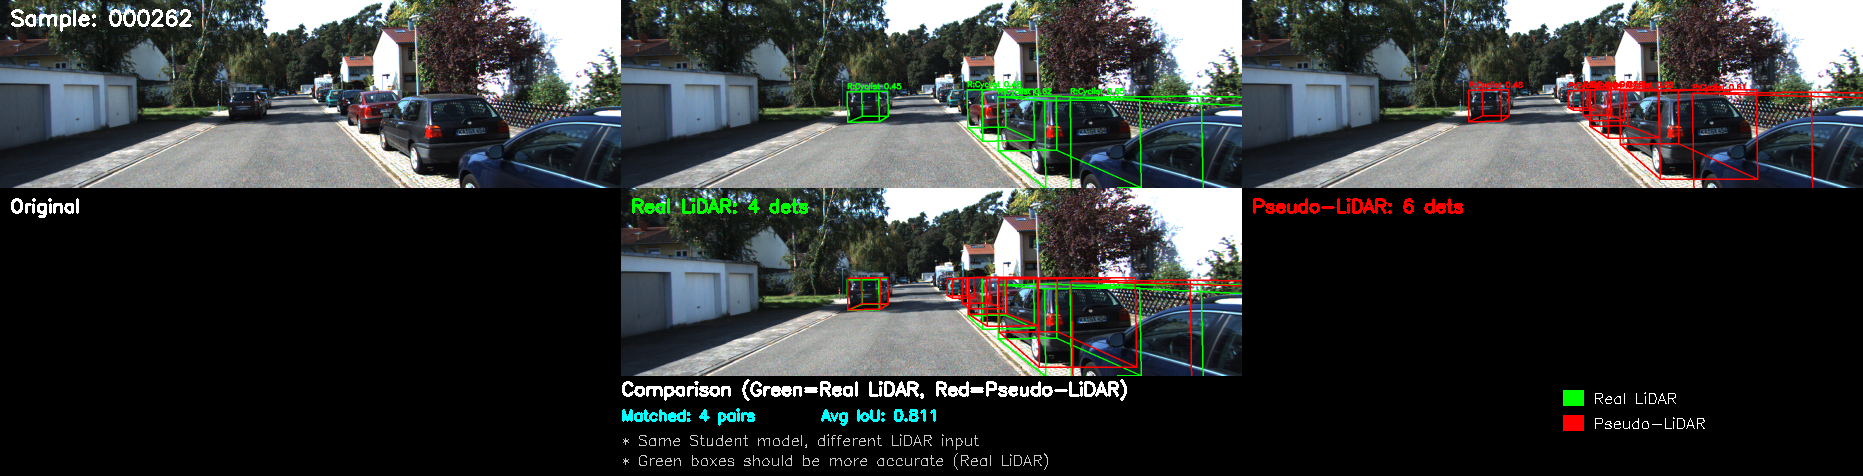


📍 comparison_000660.png


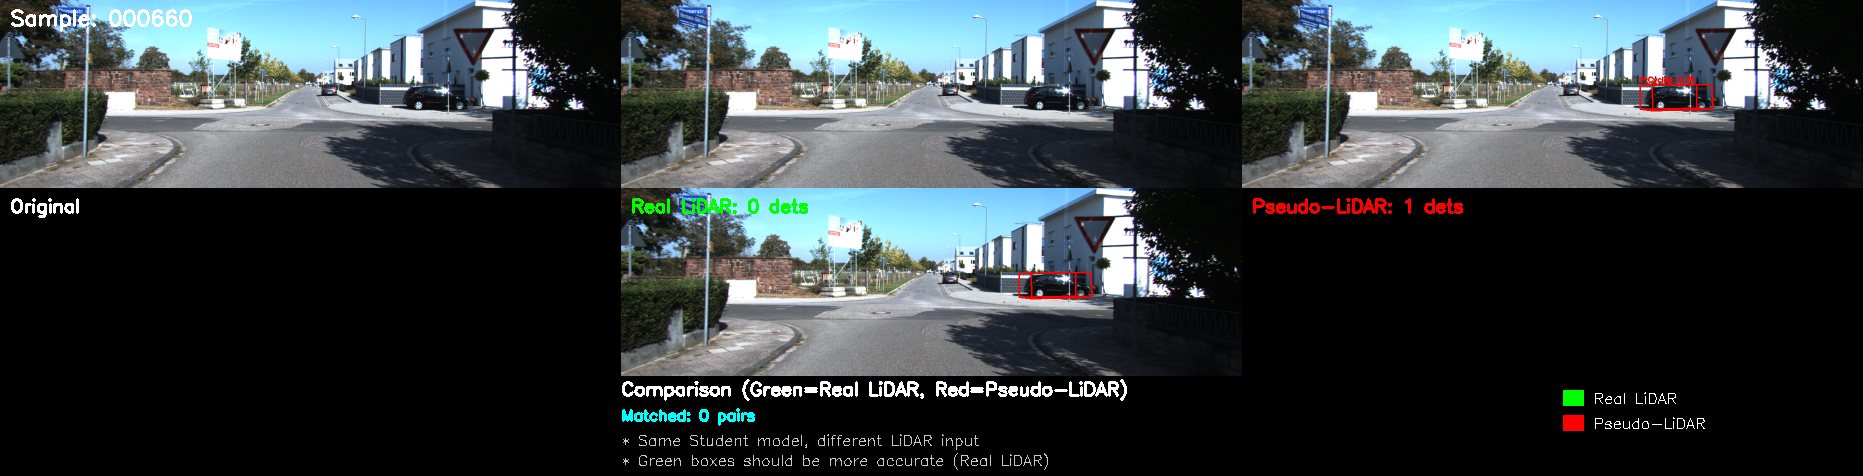


📍 comparison_003373.png


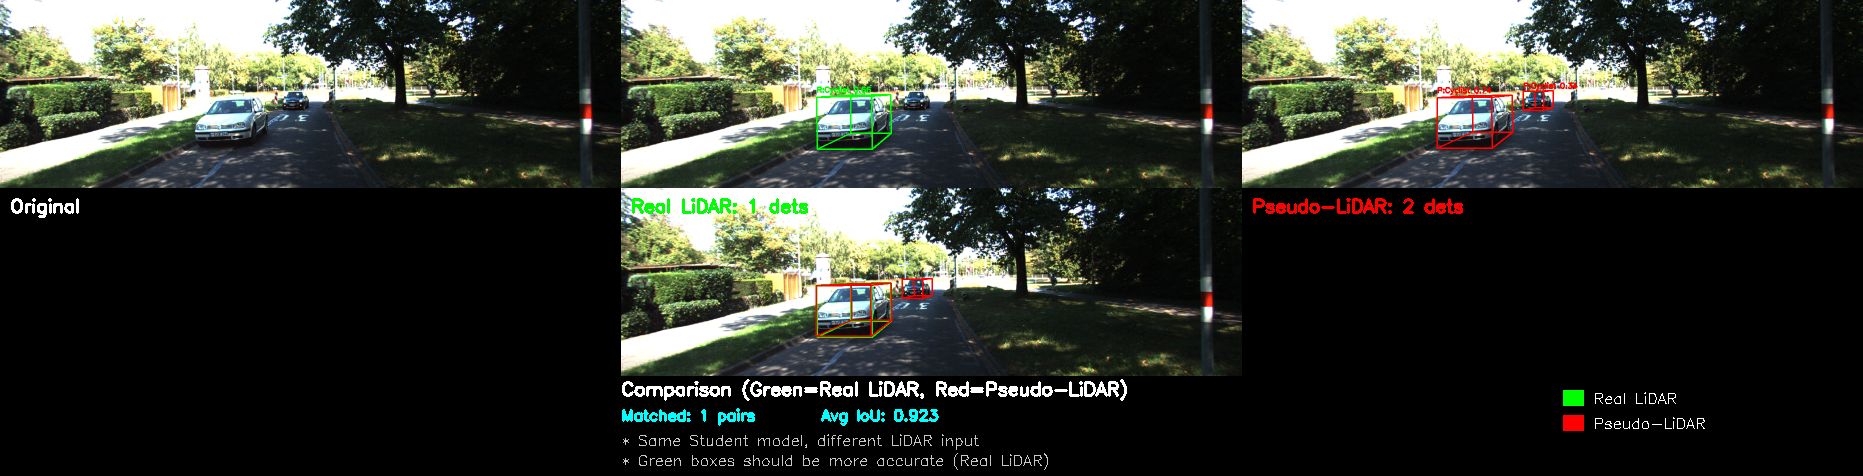


📍 comparison_003649.png


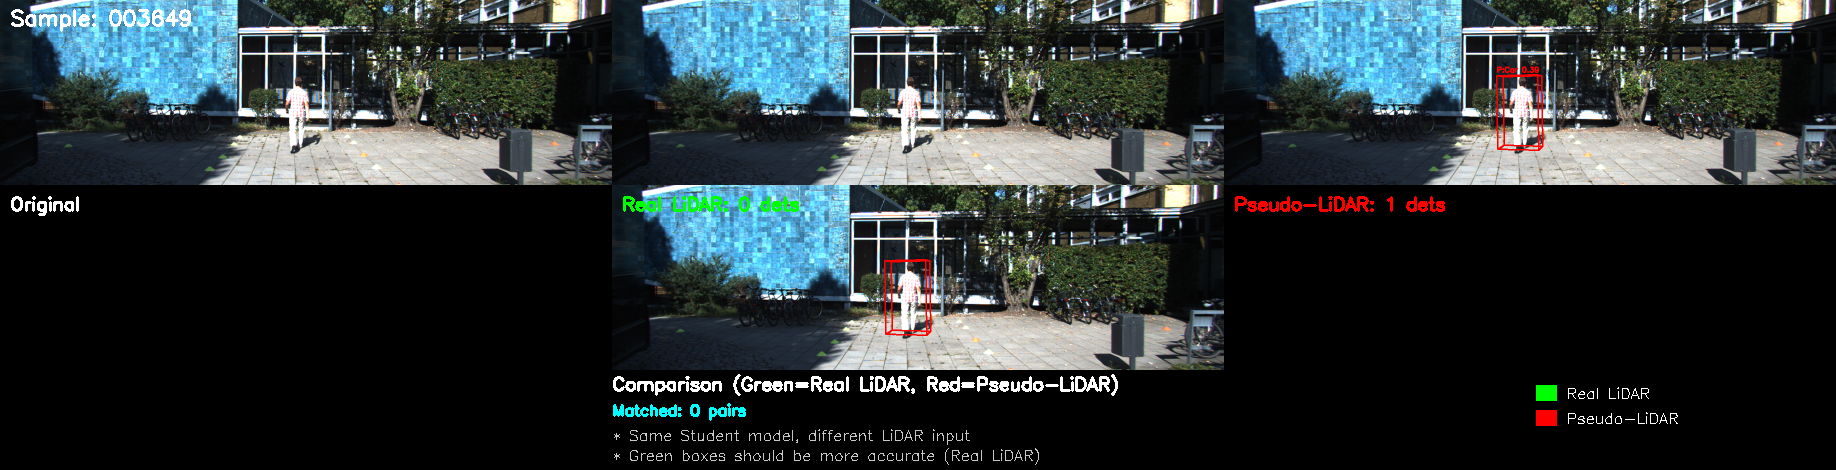


📍 comparison_006576.png


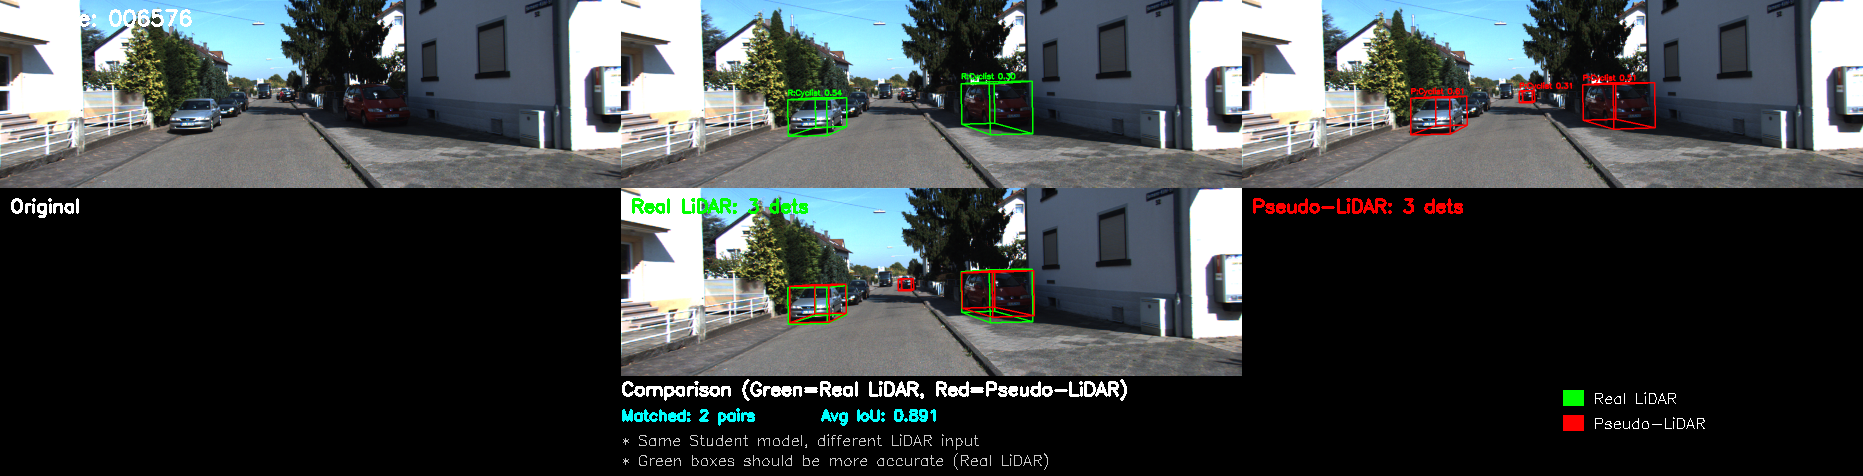

In [58]:
# 결과 이미지 표시 (v2)
import os
from IPython.display import Image, display
import glob

output_dir = '/content/mmdetection3d/comparison_output_v2'
image_files = sorted(glob.glob(os.path.join(output_dir, 'comparison_*.png')))

if image_files:
    print(f"📸 Real LiDAR vs Pseudo-LiDAR 비교 결과 ({len(image_files)}개)")
    print("="*70)
    print("🟢 녹색 박스: Real LiDAR 입력 시 Detection")
    print("🔴 빨간색 박스: Pseudo-LiDAR 입력 시 Detection")
    print("📌 동일한 Student 모델 사용 - 입력 데이터만 다름")
    print("="*70 + "\n")

    for img_path in image_files:
        print(f"\n📍 {os.path.basename(img_path)}")
        display(Image(filename=img_path, width=1200))
else:
    print("❌ 생성된 이미지가 없습니다.")